# Importando las librerías y funciones básicas

In [1]:
#Librería de graficación
import matplotlib.pyplot as plt
import matplotlib as mp
import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import metpy.calc as mpcalc
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.gridspec as gsa
import matplotlib.ticker as mticker
from mpl_toolkits.basemap import Basemap
from matplotlib import pyplot, transforms
from scipy.stats import pearsonr,spearmanr


#Librerías de procesamiento matemático y lectura de archivos
import numpy as np
import netCDF4 as nc
import pandas as pd
import glob
import os
from scipy import signal
import qgrid


#Librería de estadística
import scipy as sp

#librería para manejo de fechas
from datetime import datetime,timedelta


# from mpl_toolkits.axes_grid1 import make_axes_locatable

#Análisis Armónico
from ttide import t_tide
from pytides.tide import Tide
# from pytides.astro import astro

plt.style.use("seaborn")
mp.rcParams['xtick.labelsize']=15
mp.rcParams['ytick.labelsize']=15

mp.rcParams['axes.labelsize']=17

In [2]:
def reading_netcdf(ruta):
    data=nc.Dataset(ruta)
    for i in data.variables:
        try:
            print (i,data.variables[i].shape,data.variables[i].units) 
        except:
            print (i,data.variables[i].shape) 
    print("\n")
    data_variables=[np.array(data[i][:]) for i in list(data.variables.keys())]
    return data_variables

# Limpieza y exploración de los datos

In [3]:
rutas = np.sort(glob.glob("../Dataset/CMEMS_ECMFW/*.nc"))

#Al estar por años se debe concatenar
for i in range(0,len(rutas)):
    if i==0:
        [adt,time,lat,lon,ugos,vgos,vgosa,sla,ugosa]=reading_netcdf(rutas[i])
    else:
        [adt,time2,lat,lon,ugos,vgos,vgosa,sla2,ugosa]=reading_netcdf(rutas[i])
        sla=np.concatenate((sla,sla2))
        time=np.concatenate((time,time2))


adt (366, 45, 185) m
time (366,) days since 1950-01-01 00:00:00
latitude (45,) degrees_north
longitude (185,) degrees_east
ugos (366, 45, 185) m/s
vgos (366, 45, 185) m/s
vgosa (366, 45, 185) m/s
sla (366, 45, 185) m
ugosa (366, 45, 185) m/s


adt (366, 45, 185) m
time (366,) days since 1950-01-01 00:00:00
latitude (45,) degrees_north
longitude (185,) degrees_east
ugos (366, 45, 185) m/s
vgos (366, 45, 185) m/s
vgosa (366, 45, 185) m/s
sla (366, 45, 185) m
ugosa (366, 45, 185) m/s


adt (366, 45, 185) m
time (366,) days since 1950-01-01 00:00:00
latitude (45,) degrees_north
longitude (185,) degrees_east
ugos (366, 45, 185) m/s
vgos (366, 45, 185) m/s
vgosa (366, 45, 185) m/s
sla (366, 45, 185) m
ugosa (366, 45, 185) m/s


adt (367, 45, 185) m
time (367,) days since 1950-01-01 00:00:00
latitude (45,) degrees_north
longitude (185,) degrees_east
ugos (367, 45, 185) m/s
vgos (367, 45, 185) m/s
vgosa (367, 45, 185) m/s
sla (367, 45, 185) m
ugosa (367, 45, 185) m/s


adt (366, 45, 185) m
tim

In [6]:
sla[sla<=-1000]=np.nan

/home/franklin/my_projects_dir/entorno_jup/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less_equal
  """Entry point for launching an IPython kernel.


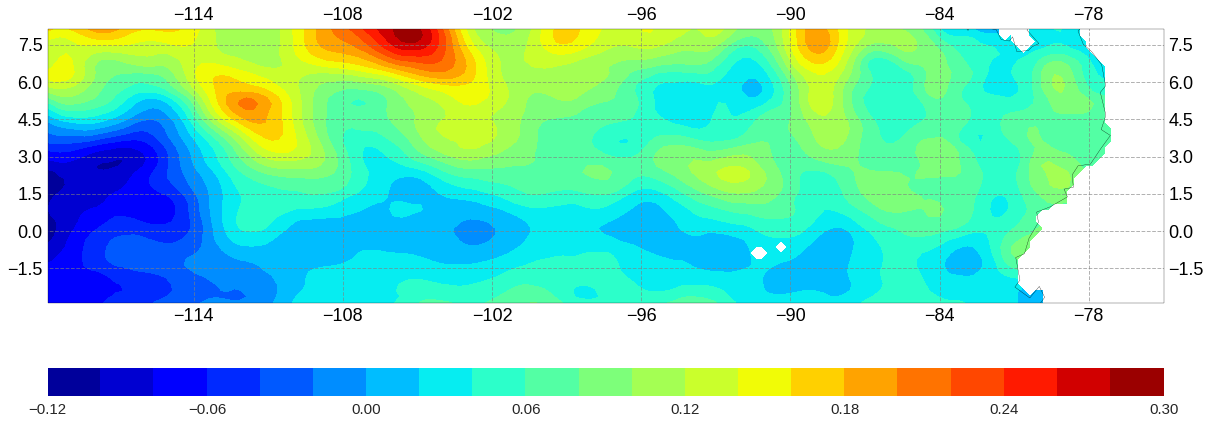

In [7]:
fig=plt.figure(figsize=(20,20))
ax=fig.add_subplot(projection=ccrs.PlateCarree())
x,y=np.meshgrid(lon,lat)
cf=ax.contourf(x,y,sla[2000,:,:],20,transform=ccrs.PlateCarree(),cmap="jet")
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.6, linestyle='--')
gl.xlabel_style = {'size': 18, 'color': 'black'}
gl.ylabel_style = {'size': 18, 'color': 'black'}
ax.coastlines()
cbar=plt.colorbar(cf,orientation="horizontal",fraction=0.1, pad=0.06,aspect=40)
cbar.ax.tick_params(labelsize=15) 

plt.show()

In [8]:
serie=np.nanmean(sla,axis=1)
serie_temp=np.nanmean(serie,axis=1)

/home/franklin/my_projects_dir/entorno_jup/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


In [9]:
da=[datetime(1950,1,1,0,0,0)+timedelta(days=int(time[w])) for w in range (0,len(time))]
date=pd.DatetimeIndex(da)

In [10]:
serie_sla=pd.Series(serie_temp,date)

Un diagrama de Hovmoller permite conocer la variación temporal de una variable integrada en las latitudes o en las latitudes.

In [11]:
new_array = np.array(date.to_pydatetime(), dtype=object)

In [12]:
sla_copy=sla

Se realiza el filtrado de la información con un suavizado anual para solo captar variaciones interanuales.

In [13]:
for la in range (sla_copy.shape[1]):
    for lo in range(sla_copy.shape[2]):
        a=sla_copy[:,la,lo]
        serie_test=pd.Series(a,index=date)
        serie_rolling=serie_test.rolling(30).mean()
        sla_copy[:,la,lo]=serie_rolling.values

## Hovmoller con las longitudes

In [14]:
x_tick_labels = [u'120\N{DEGREE SIGN}W', u'110\N{DEGREE SIGN}W',
                 u'100\N{DEGREE SIGN}W', u'90\N{DEGREE SIGN}W',
                 u'80\N{DEGREE SIGN}W']

y_tick_labels = [u'-2\N{DEGREE SIGN}N', u'0\N{DEGREE SIGN}N',
                 u'2\N{DEGREE SIGN}N', u'4\N{DEGREE SIGN}N',
                 u'6\N{DEGREE SIGN}N',u'8\N{DEGREE SIGN}N']

/home/franklin/my_projects_dir/entorno_jup/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


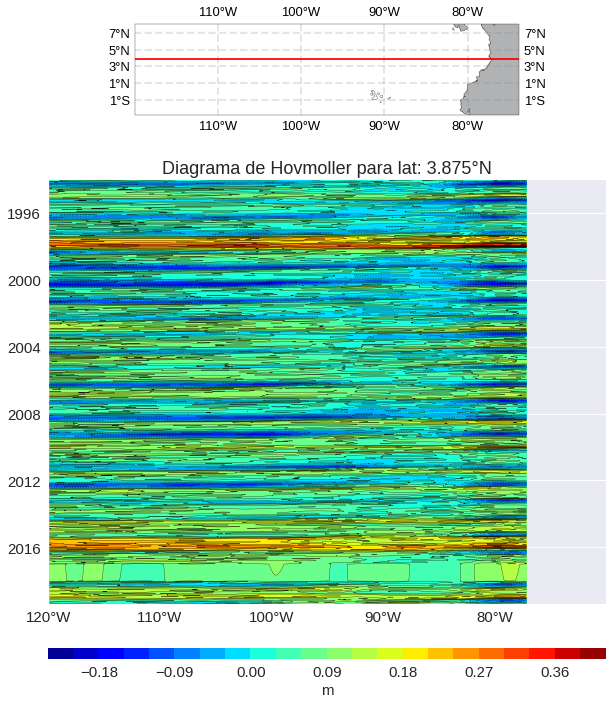

In [15]:
fig=plt.figure(figsize=(10,13))

gs = gsa.GridSpec(nrows=2, ncols=1,height_ratios=[1,6],hspace=0.2)

x_tick_labels = [u'120\N{DEGREE SIGN}W', u'110\N{DEGREE SIGN}W',
                 u'100\N{DEGREE SIGN}W', u'90\N{DEGREE SIGN}W',
                 u'80\N{DEGREE SIGN}W']

y_tick_labels = [u'-2\N{DEGREE SIGN}N', u'0\N{DEGREE SIGN}N',
                 u'2\N{DEGREE SIGN}N', u'4\N{DEGREE SIGN}N',
                 u'6\N{DEGREE SIGN}N',u'8\N{DEGREE SIGN}N']

xlocs=np.arange(-120, -60, 10)
ylocs=np.arange(-3,10,2)

# Acerca del primer subplot
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax1.set_extent([lon[0], lon[-1], lat[0],lat[-1]], ccrs.PlateCarree())
ax1.coastlines('50m')
ax1.add_feature(cartopy.feature.LAND, zorder=0,facecolor='#B1B2B4')
ax1.plot([lon[0],lon[-1]],[lat[27],lat[27]],color='red',transform=ccrs.PlateCarree())

gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.2, linestyle='--',
                   xlocs=xlocs,ylocs=ylocs)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 13, 'color': 'black'}
gl.ylabel_style = {'size': 13, 'color': 'black'}

# plt.title('CMEMS Reanalysis',y=1.3, loc='right',fontsize=18)

# Acerca del segundo subplot
ax2 = fig.add_subplot(gs[1, 0])
ax2.invert_yaxis()  # Reverse the time order to do oldest first
ax2.set_title('Diagrama de Hovmoller para lat: '+str(lat[27])+"°N",fontsize=18)

x,y=np.meshgrid(lon,new_array)
cf=ax2.contourf(x,y,sla_copy[:,27,:],20,cmap="jet")
cr=ax2.contour(x,y,sla_copy[:,27,:],20,colors="k",linewidths=0.3)
cbar = plt.colorbar(cf, orientation='horizontal', pad=0.08, aspect=50)
cbar.set_label('m',fontsize=15)
cbar.ax.tick_params(labelsize=15) 

ax2.set_xticks(np.array(xlocs)+360)
ax2.set_xticklabels(x_tick_labels)
ax2.set_ylim((new_array[-1],new_array[365]))

ax2.tick_params(labelsize=15)
plt.savefig('./Plots/hovmoller_lon.png',dpi=600,bbox_inches="tight")

### Interpolando los datos a resoluciones espaciales menores.

In [16]:
new_lon=np.arange(240,286,1)
sla_copy_mod=np.zeros((sla_copy.shape[0],len(new_lon)))
for i in range(sla_copy.shape[0]):
    sla_copy_mod[i,:]=np.interp(new_lon,lon,sla_copy[i,27,:])

In [17]:
new_lat=np.arange(-3,10,1)
sla_copy_mod2=np.zeros((len(new_lat),sla_copy.shape[0]))
for i in range(sla_copy.shape[0]):
    sla_copy_mod2[:,i]=np.interp(new_lat,lat,sla_copy[i,:,111])

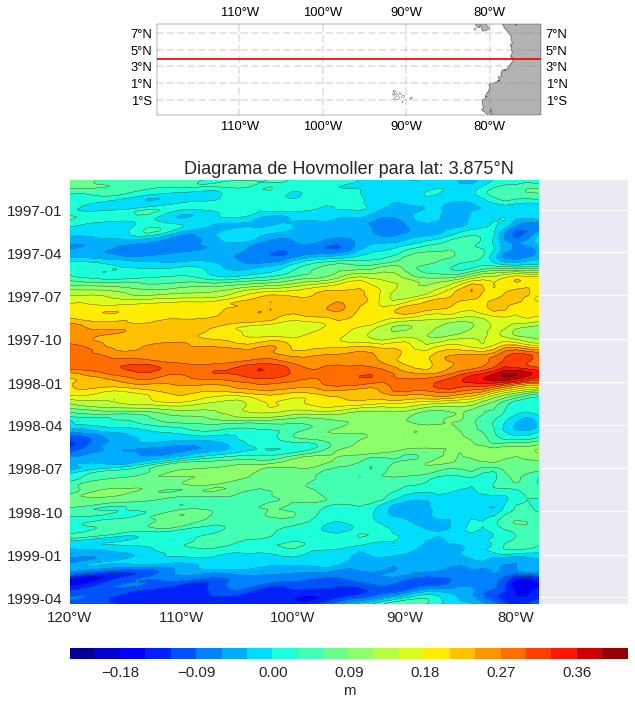

In [18]:
fig=plt.figure(figsize=(10,13))

gs = gsa.GridSpec(nrows=2, ncols=1,height_ratios=[1,6],hspace=0.2)

x_tick_labels = [u'120\N{DEGREE SIGN}W', u'110\N{DEGREE SIGN}W',
                 u'100\N{DEGREE SIGN}W', u'90\N{DEGREE SIGN}W',
                 u'80\N{DEGREE SIGN}W']

y_tick_labels = [u'-2\N{DEGREE SIGN}N', u'0\N{DEGREE SIGN}N',
                 u'2\N{DEGREE SIGN}N', u'4\N{DEGREE SIGN}N',
                 u'6\N{DEGREE SIGN}N',u'8\N{DEGREE SIGN}N']

xlocs=np.arange(-120, -60, 10)
ylocs=np.arange(-3,10,2)

# Acerca del primer subplot
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax1.set_extent([lon[0], lon[-1], lat[0],lat[-1]], ccrs.PlateCarree())
ax1.coastlines('50m')
ax1.add_feature(cartopy.feature.LAND, zorder=0,facecolor='#B1B2B4')
ax1.plot([lon[0],lon[-1]],[lat[27],lat[27]],color='red',transform=ccrs.PlateCarree())

gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.2, linestyle='--',
                   xlocs=xlocs,ylocs=ylocs)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 13, 'color': 'black'}
gl.ylabel_style = {'size': 13, 'color': 'black'}

# plt.title('CMEMS Reanalysis',y=1.3, loc='right',fontsize=18)

# Acerca del segundo subplot
ax2 = fig.add_subplot(gs[1, 0])
ax2.invert_yaxis()  # Reverse the time order to do oldest first
ax2.set_title('Diagrama de Hovmoller para lat: '+str(lat[27])+"°N",fontsize=18)

x,y=np.meshgrid(new_lon,new_array)
cf=ax2.contourf(x,y,sla_copy_mod[:,:],20,cmap="jet")
cr=ax2.contour(x,y,sla_copy_mod[:,:],20,colors="k",linewidths=0.3)
cbar = plt.colorbar(cf, orientation='horizontal', pad=0.08, aspect=50)
cbar.set_label('m',fontsize=15)
cbar.ax.tick_params(labelsize=15) 

ax2.set_xticks(np.array(xlocs)+360)
ax2.set_xticklabels(x_tick_labels)
ax2.set_ylim((new_array[2300],new_array[1400]))

ax2.tick_params(labelsize=15)
plt.savefig('./Plots/hovmoller_lon_mod.png',dpi=600,bbox_inches="tight")

**La pregunta de investigación que surgiría es: ¿Los incrementos de nivel del mar en Buenaventura (tasas altas) se han registrado antes en una mayor longitud (mar adentro)?**

## Hovmoller con las latitudes

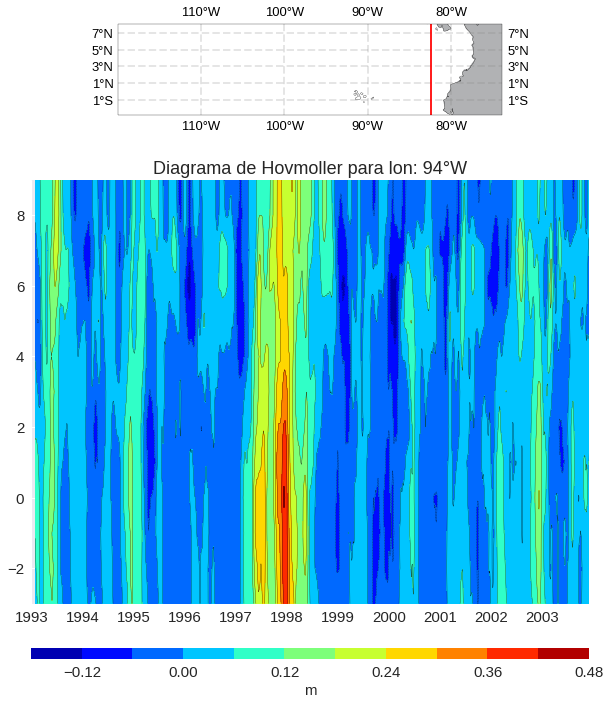

In [19]:
fig=plt.figure(figsize=(10,13))

gs = gsa.GridSpec(nrows=2, ncols=1,height_ratios=[1,6],hspace=0.2)

x_tick_labels = [u'120\N{DEGREE SIGN}W', u'110\N{DEGREE SIGN}W',
                 u'100\N{DEGREE SIGN}W', u'90\N{DEGREE SIGN}W',
                 u'80\N{DEGREE SIGN}W']

y_tick_labels = [u'-2\N{DEGREE SIGN}N', u'0\N{DEGREE SIGN}N',
                 u'2\N{DEGREE SIGN}N', u'4\N{DEGREE SIGN}N',
                 u'6\N{DEGREE SIGN}N',u'8\N{DEGREE SIGN}N']

xlocs=np.arange(-120, -60, 10)
ylocs=np.arange(-3,10,2)

# Acerca del primer subplot
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax1.set_extent([lon[0], lon[-1], lat[0],lat[-1]], ccrs.PlateCarree())
ax1.coastlines('50m')
ax1.add_feature(cartopy.feature.LAND, zorder=0,facecolor='#B1B2B4')
ax1.plot([lon[150],lon[150]],[lat[0],lat[-1]],color='red',transform=ccrs.PlateCarree())

gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.2, linestyle='--',
                   xlocs=xlocs,ylocs=ylocs)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 13, 'color': 'black'}
gl.ylabel_style = {'size': 13, 'color': 'black'}

# plt.title('CMEMS Reanalysis',y=1.3, loc='right',fontsize=18)

# Acerca del segundo subplot
ax2 = fig.add_subplot(gs[1, 0])
ax2.set_title('Diagrama de Hovmoller para lon: '+str(360-new_lon[26])+"°W",fontsize=18)

x,y=np.meshgrid(new_array,new_lat)
cf=ax2.contourf(x,y,sla_copy_mod2[:,:],10,cmap="jet")
cr=ax2.contour(x,y,sla_copy_mod2[:,:],10,colors="k",linewidths=0.3)
cbar = plt.colorbar(cf, orientation='horizontal', pad=0.08, aspect=50)
cbar.set_label('m',fontsize=15)
cbar.ax.tick_params(labelsize=15) 

# ax2.set_xticks(np.array(xlocs)+360)
# ax2.set_xticklabels(x_tick_labels)
# ax2.set_xlim((new_array[365],new_array[-1]))
ax2.set_xlim((new_array[0],new_array[4000]))


ax2.tick_params(labelsize=15)

Revisando el diagrama de Hovmoller para las longitudes puede intuirse que si existe una zona más hacia el oeste donde también ocurren las altas tasas de nivel medio del mar que se registran en Buenaventura.

Para comparar las tasas de nivel medio del mar de 2016-2019 (zona con mayores incrementos) con otros períodos, se calculan las tasas de cambio en ventanas de 3 años

<center><font size="6"> Análisis del Mareógrafo de Buenaventura<font size> <center>
    
***

# Recopilando la información y análisis de 2019

In [17]:
fecha_inicio=datetime(1970,1,1)
fecha_inicio2=datetime(1980,1,1)
fecha_fin=datetime(2019,1,1)
fecha_fin2=datetime(1986,1,1)

## Cargue de información de nivel del mar

In [2]:
df_nmm=pd.read_csv(r"../Dataset/rqh0085a.csv")
fechas=[datetime(df_nmm.Year.loc[i],df_nmm.Month.loc[i],df_nmm.Day.loc[i],df_nmm.Hour.loc[i]) for i in range(len(df_nmm))]
serie_nmm=pd.Series(data=df_nmm.nmm.values/1000,index=fechas)
# serie_nmm=serie_nmm[fecha_inicio:]

In [3]:
serie_real=serie_nmm-np.mean(serie_nmm) #Anomalías de la serie

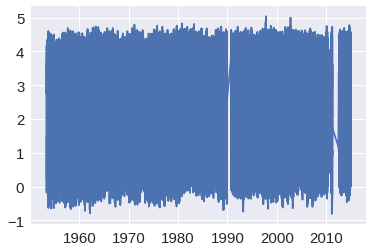

In [20]:
plt.plot(serie_nmm)
plt.show()

## Calculando el porcentaje de datos faltantes por año:

In [21]:
data_nmm=pd.DataFrame(serie_nmm,columns=["nmm"])
data_nmm["year"]=data_nmm.index.year
data_nmm_year=data_nmm.groupby("year").count()

In [22]:
porcentajes=np.zeros((int(len(data_nmm_year.index)),1))
for i,z in enumerate(data_nmm_year.index):
    d=(lambda year : (year % 400 == 0) or (year % 4 == 0 and year % 100 != 0))(z)
    if d==True:
        dv=366*24
        porcentajes[i]=((dv-data_nmm_year.nmm[z])/(dv))*100
    else:
        dv=365*24
        porcentajes[i]=((dv-data_nmm_year.nmm[z])/(dv))*100

In [23]:
df_faltantes=pd.DataFrame(porcentajes,index=data_nmm_year.index,columns=["Datos faltantes [%]"])

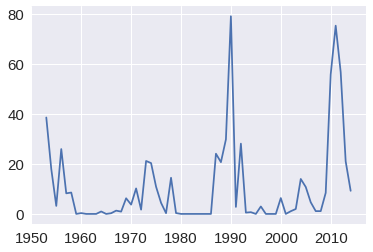

In [24]:
plt.plot(df_faltantes)

## Sensibilidad de la componente M2 respecto a la cantidad de información tomada

In [25]:
fecha_inicio=datetime(1993,1,1)
amps_m2=np.ones((15,1))

for i in range(0,15,1):
    ttide=t_tide(serie_real[fecha_inicio:datetime(1993+i+1,1,1)],dt=1,out_style=None)
    ttide_out=ttide
    idx_m2=np.where(ttide_out["nameu"]==b'M2  ')[0]
    amps=ttide_out["tidecon"][:,0]
    amp_m2=amps[idx_m2]
    amps_m2[i]=amp_m2

/home/franklin/Documentos/GitHub/TDG/Scripts/ttide/t_tide.py:295: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef = np.linalg.lstsq(tc[gd, :], xin[gd])[0].T
/home/franklin/my_projects_dir/entorno_jup/lib/python3.6/site-packages/numpy/lib/type_check.py:161: FutureWarning: `real` is deprecated and will be removed in a future version. To eliminate this warning for a Series `ser`, use `np.real(ser.to_numpy())` or `ser.to_numpy().real`.
  return val.real
/home/franklin/my_projects_dir/entorno_jup/lib/python3.6/site-packages/numpy/lib/type_check.py:204: FutureWarning: `imag` is deprecated and will be removed in a future version. To eliminate this warning for a Series `ser`, use `np.imag(ser.to_numpy())` or `ser.to_numpy().imag`.
  return val.imag


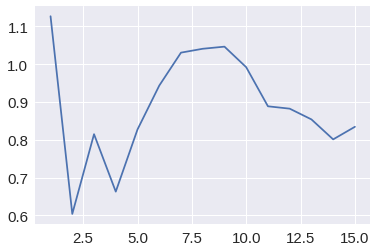

In [26]:
plt.plot(np.arange(1,16,1),amps_m2)

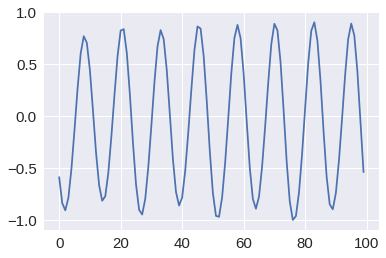

In [27]:
datos_astro=ttide_out["xout"].ravel()
plt.plot(datos_astro[:100])

## Recreando la serie completa desde ttide

In [28]:
ttide=t_tide(serie_real[fecha_inicio2:fecha_fin2],dt=1,out_style=None)
ttide_out=ttide

freqs=ttide_out["fu"]
amps=ttide_out["tidecon"][:,0]
phases=ttide_out["tidecon"][:,2]
amps_err=ttide_out["tidecon"][:,1]

suma_total=np.zeros((len(serie_real[fecha_inicio2:fecha_fin2]),))*1j
t=np.arange(0,len(serie_real[fecha_inicio2:fecha_fin2]))
for ix in range(0,len(freqs)):
    suma_total+=(amps[ix]+amps_err[ix])*np.exp(1j*(freqs[ix]*2*np.pi*t+phases[ix]))
#     suma_total+=amplitud*(np.cos(nmm_freq[ix]*2*np.pi*t+fase)+1j*np.sin(nmm_freq[ix]*2*np.pi*t+fase))


/home/franklin/my_projects_dir/entorno_jup/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


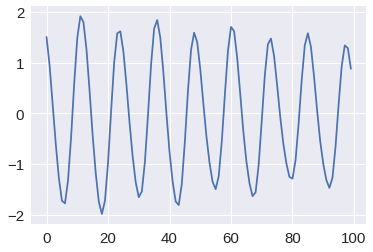

In [29]:
plt.plot(suma_total[:100])

## Determinación de la marea astronómica

La herramienta empleada es Pytides, una librería de Python que realiza el análisis armónico de la marea.

In [30]:
#Script de Víctor Saavedra

# marea = niveles-nmm
# tide = Tide.decompose(marea, tiempos)
# tide1 = Tide(model = tide.model, radians = False)
# astronomica = tide1.at(tiempos)
# meteo = marea-tide1.at(tiempos)

In [4]:
tide = Tide.decompose(serie_real.values,serie_real.index)
tide1 = Tide(model = tide.model, radians = False)
astronomica = tide1.at(serie_real.index)
serie_astronomica=pd.Series(astronomica,index=serie_real.index)

In [5]:
serie_residual=serie_real-serie_astronomica

In [6]:
fechas_null=serie_residual.index[np.where((serie_residual>0.5) | (serie_residual<-0.5)) ]
serie_residual=serie_residual.drop(fechas_null)

(-1, 1)

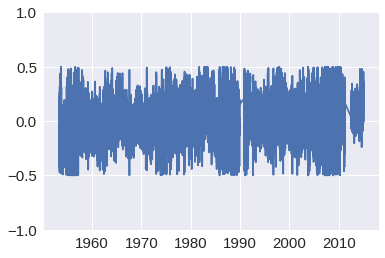

In [34]:
plt.figure()
plt.plot(serie_residual)
plt.ylim(-1,1)

(array([711858., 715510., 719163., 722815., 726468., 730120., 733773.,
        737425.]), <a list of 8 Text xticklabel objects>)

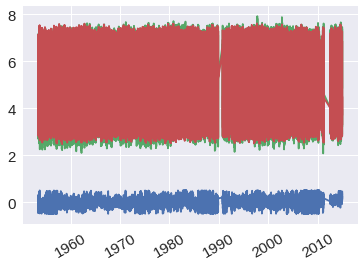

In [35]:
# %matplotlib notebook
plt.figure()
plt.plot(serie_residual)
plt.plot(serie_residual.iloc[np.where(serie_residual>0.6)],c='k')

plt.plot(serie_real+5,label="real")
plt.plot(serie_astronomica+5,label="astronómica")
plt.xticks(rotation=30)

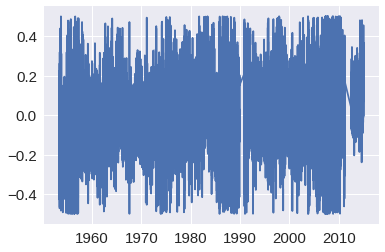

In [36]:
plt.figure()
plt.plot(serie_residual)

/home/franklin/my_projects_dir/entorno_jup/lib/python3.6/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/franklin/my_projects_dir/entorno_jup/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


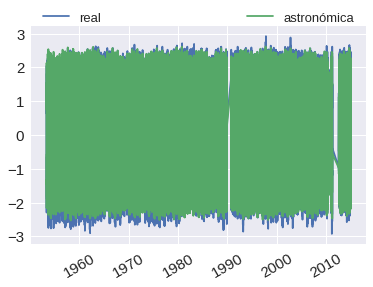

In [37]:
plt.figure()
plt.plot(serie_real,label="real")
plt.plot(serie_astronomica,label="astronómica")
plt.xticks(rotation=30)
plt.legend(prop={'size':13},mode="expand",bbox_to_anchor=(0,1.02,1,0.1),ncol=2)

## Componentes armónicas importantes

In [38]:
constituent = [c.name for c in tide.model['constituent']]
df = pd.DataFrame(tide.model, index=constituent).drop('constituent', axis=1)
df.sort_values('amplitude', ascending=False).head(10)
print('Form number %s, the tide is %s.' %
      (tide.form_number()[0], tide.classify()))
df

Form number 0.07404437171080588, the tide is semidiurnal.


amplitude       phase
Z0       8.818746e-16  180.000000
M2       1.496180e+00  254.876106
S2       4.020873e-01  314.505943
N2       3.143344e-01  225.782371
K1       1.148958e-01   62.672819
M4       6.526875e-02  222.617288
O1       2.566022e-02   72.832462
M6       1.904818e-03   47.834515
MK3      4.724058e-03   30.646567
S4       8.254021e-03   10.961457
MN4      2.761133e-02  204.191259
nu2      5.463701e-02  229.113165
S6       1.590922e-04  310.794195
mu2      4.825813e-02  231.885963
2N2      4.019469e-02  199.247975
OO1      7.892819e-03  102.969480
lambda2  1.745960e-02  235.330271
S1       1.751115e-02  153.964161
M1       7.883759e-04  220.433357
J1       9.315281e-03   91.030707
Mm       1.686856e-02   33.013369
Ssa      5.068172e-02  143.731352
Sa       7.491347e-02  167.100683
MSF      1.822784e-02   65.976966
Mf       1.561979e-02   24.217108
rho1     1.021653e-03  112.724673
Q1       5.392940e-03  140.126755
T2       2.518584e-02  325.095421
R2       3.346328e-03  275.492169
2Q1      1.470813e-03  140.474764
P1       3.456818e-02   63.412879
2SM2     9.899597e-03  129.638903
M3       5.713051e-03   28.408009
L2       4.269700e-02  261.067483
2MK3     3.216973e-03  224.681572
K2       1.043465e-01  310.487260
M8       7.865417e-03  109.287571
MS4      4.251314e-02  292.979985

In [39]:
# def astronomica(serie_real):
#     ttide=t_tide(serie_real,dt=1)
#     ttide_out=ttide
#     datos_astro=ttide_out["xout"].ravel()
#     serie_astro=pd.Series(data=datos_astro,index=serie_real.index)
#     return serie_astro

# serie_astro=astronomica(serie_real[fecha_inicio2:fecha_fin2])

Según información recolectada, el mayor aporte a la marea lo da la componente $M_{2}$ (principal lunar), por lo tanto es semidiurno (**tiene todo el sentido del mundo**)

Aportes principales:

- $M_{2}$: Principal lunar, 150.09 cm
- $S_{2}$: Principal solar, 40.25 cm
- $N_{2}$: Lunar mayor elíptica, 31.66 cm
- $K_{2}$: Lunar-solar declinacional, 10.97 cm
- $K_{1}$: Lunar-solar diurna declinacional, 11.25 cm


EL link de la info es [Caracterización de la marea](http://www.ideam.gov.co/documents/21021/23877/Caracterizaci%C3%B3n+de+la+Marea+%282010%29.pdf/a8ed71d8-3d7f-4a88-bed5-796c542aff4f)


## Suavizado de la información

Con el fin de que la visualización de la información sea más clara y ordenada, se realiza un suavizado de cada 30 horas.

In [128]:
def smooth(y,box_pts):fechas
    box=np.ones(box_pts)/box_pts
    y_smooth=np.convolve(y,box,mode="same")
    return y_smooth

In [141]:
def maximos(serie_residual,inicio,fin):
    maximos_residual,fechas_residual=[],[]
#     maximos_astro,fechas_astro=[],[]
    c_dias=((fin-inicio).days)+1
    for k in range(int(c_dias)):

        #Ventana de marea residual
        window_residual=serie_residual[inicio+timedelta(days=int(k)):inicio+timedelta(days=int(k+1))
                                       -timedelta(hours=1)]
        max_window_residual=np.max(window_residual)

        #Ventana de marea astronómica
#         window_astro=serie_astro[inicio+timedelta(days=int(k)):inicio+timedelta(days=int(k+1))
#-timedelta(hours=1)]
#         max_window_astro=np.max(window_astro)

        maximos_residual.append(max_window_residual)
        fechas_residual=pd.date_range(inicio,fin,freq="D")

    #Series de máximos
    serie_maximos_residual=pd.Series(data=maximos_residual,index=fechas_residual)
    return serie_maximos_residual

serie_max_residual=maximos(serie_residual,serie_residual.index[0],serie_residual.index[-1])

In [144]:
def smoothed(serie_max_residual,ventana):
    serie_dif_maximos=serie_max_residual
    dif_maximos_smoothed=smooth(serie_dif_maximos,ventana)
    serie_maximos_smoothed=pd.Series(data=dif_maximos_smoothed,index=serie_dif_maximos.index)
    return serie_dif_maximos,serie_maximos_smoothed

In [176]:
serie_dif_maximos,serie_maximos_smoothed=smoothed(serie_max_residual,60)

<IPython.core.display.Javascript object>


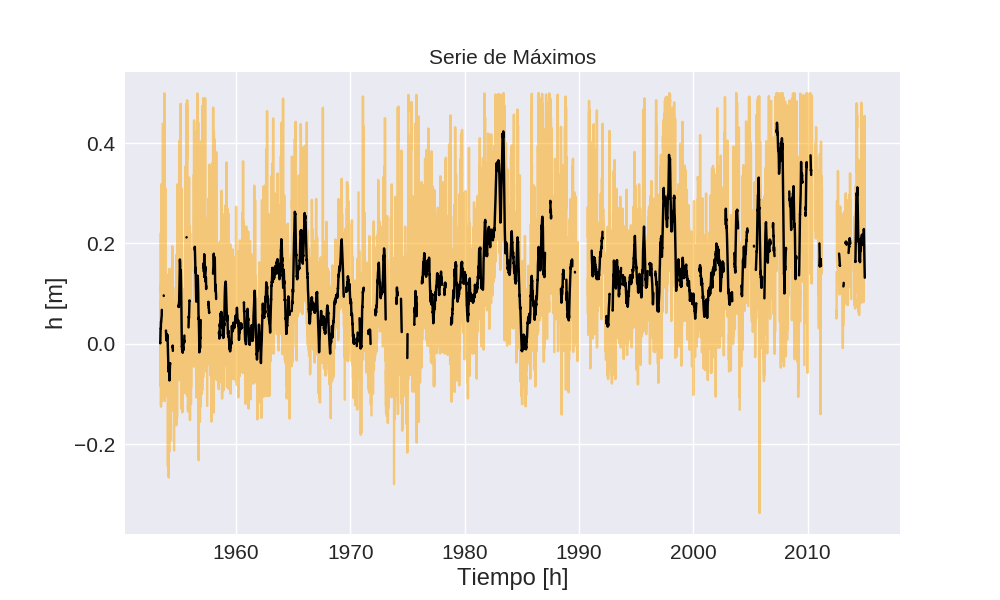

Text(0.5, 0, 'Tiempo [h]')

In [177]:
# %matplotlib notebook
plt.figure(figsize=(10,6))
plt.title("Serie de Máximos",fontsize=15)
plt.plot(serie_dif_maximos,c="orange",alpha=0.5)
plt.plot(serie_maximos_smoothed,c="k")
plt.ylabel("h [m]")
plt.xlabel("Tiempo [h]")

In [173]:
serie_max_smooth=serie_max_residual.rolling(60).mean()

<IPython.core.display.Javascript object>


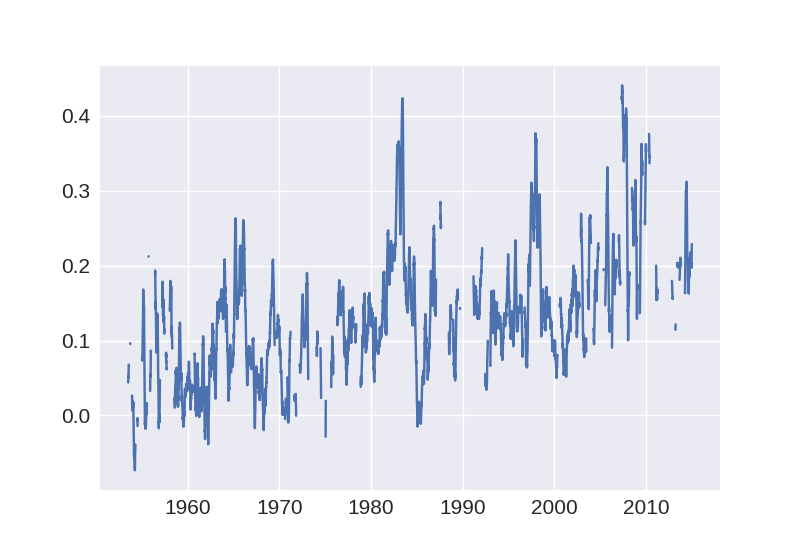

In [178]:
plt.figure()
plt.plot(serie_max_smooth)
# plt.plot(serie_maximos_smoothed)

## Datos y Eventos ENSO desde el índice ONI y MEI

In [12]:
dataset_oni=pd.read_excel(r"../Dataset/oni index.xlsx").set_index("Year")
dataset_mei=pd.read_excel(r"../Dataset/mei index.xlsx").set_index("Year")

In [13]:
def serie_oni(dataset_oni,a,b):
    data=dataset_oni.values.ravel()
    fechas=pd.date_range("1950-01-01","2019-01-01",freq="M")
    date=[i-timedelta(days=15) for i in fechas]
    serie_oni_d=pd.Series(data=data,index=date)[a:b]
    return serie_oni_d

In [14]:
def serie_mei(dataset_mei,a,b):
    data=dataset_mei.values.ravel()
    fechas=pd.date_range("1979-01-01","2019-01-01",freq="M")
    date=[i-timedelta(days=15) for i in fechas]
    serie_mei_d=pd.Series(data=data,index=date)[a:b]
    return serie_mei_d

In [15]:
Serie_oni=serie_oni(dataset_oni,serie_residual.index[0],serie_residual.index[-1])
Serie_mei=serie_mei(dataset_mei,serie_residual.index[0],serie_residual.index[-1])

In [16]:
def looking_for_events(Serie_oni):
    loc_niña=[] #Revisar siempre estas posiciones
    loc_niño=[]
    for i in range (4,int(len(Serie_oni)-4)):
        k,d,z=0,0,0
        while k<5:
            a=i+k-4
            b=i+k+1
            window=np.around(np.asarray((Serie_oni.values[a:b])),1)
            test_niño=window>=0.5
            test_niña=window<=-0.5
            if test_niño.all()==True:
                d=d+1
            if test_niña.all()==True:
                z=z+1
            k=k+1
        if d>=1:
            loc_niño.append(i)
        if z>=1:
            loc_niña.append(i)
    return loc_niña,loc_niño

In [17]:
def looking_for_eventsMEI(Serie_mei):
    locs_niña_mei=[]
    locs_niño_mei=[]
    for i in range (0,len(Serie_mei)):
        if round(Serie_mei[i],2)>=0.5:
            locs_niño_mei.append(i)
        elif round(Serie_mei[i],2)<=-0.5:
            locs_niña_mei.append(i)
    return locs_niño_mei,locs_niña_mei

In [18]:
locs_niño2,locs_niña2=looking_for_eventsMEI(Serie_mei)     

locs_niña,locs_niño=looking_for_events(Serie_oni)     

In [19]:
def events(loc_niño,loc_niña):
    fines_niña=np.where(np.diff(loc_niña)!=1)[0].tolist()+[len(loc_niña)-1]
    fines_niño=np.where(np.diff(loc_niño)!=1)[0].tolist()+[len(loc_niño)-1]
    inicios_niña=[0]+[i+1 for i in fines_niña][:-1]
    inicios_niño=[0]+[i+1 for i in fines_niño][:-1]
    return inicios_niño,fines_niño,inicios_niña,fines_niña

In [20]:
inicio_niño,fin_niño,inicio_niña,fin_niña=events(locs_niño,locs_niña)
inicio_niño2,fin_niño2,inicio_niña2,fin_niña2=events(locs_niño2,locs_niña2)

In [21]:
def plotting_events(Serie_oni,inicio_niño,fin_niño,locs_niño,inicio_niña,fin_niña,locs_niña):
    fig,ax=plt.subplots(1,1,figsize=(12,6))
    ax.plot(Serie_oni,'-o',c='k')
    ax.set_title("Eventos ENSO")
#     ax.set_yticks(np.arange(-3,3,0.5))
    ax.grid()
    for i,k in zip(inicio_niño,fin_niño): #Niño y después niña
        ax.fill_betweenx([-3,3],Serie_oni.index[locs_niño[i]],Serie_oni.index[locs_niño[k]],color="r",alpha=0.4)
    for j,m in zip(inicio_niña,fin_niña): #Niño y después niña
        ax.fill_betweenx([-3,3],Serie_oni.index[locs_niña[j]],Serie_oni.index[locs_niña[m]],color="b",alpha=0.4) 
    plt.grid()
    plt.savefig(".\Plots\Eventos_ENSO.png",dpi=400,box_inches="tight")
    return fig

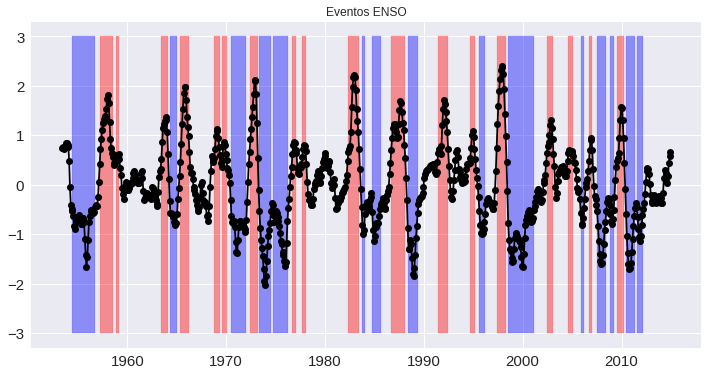

In [56]:
plots_ENSO=plotting_events(Serie_oni,inicio_niño[1:],fin_niño[1:],locs_niño,inicio_niña,fin_niña,locs_niña)

## Traslapando la información

In [205]:
def correlation (serie2,b):
    
    corr=[pearsonr(serie_def[:-i],serie2[i:])[0] for i in range(1,13)[::-1]]
    corr=corr+[pearsonr(serie_def,serie2)[0]]+[pearsonr(serie_def[i:],serie2[:-i])[0]
        for i in range(1,13)]
    
    corr2=[spearmanr(serie_def[:-i],serie2[i:])[0] for i in range(1,13)[::-1]]
    corr2=corr2+[spearmanr(serie_def,serie2)[0]]+[spearmanr(serie_def[i:],serie2[:-i])[0] for i in range(1,13)]
    
    
    fig=plt.figure(figsize=(8,4))
    ax=fig.add_subplot(211)
    ax.bar(range(-12,13),corr,color='firebrick')
    ax.set_title('Correlación de Pearson nmm-'+b)
#     ax.set_ylabel(u'Pearson')
    ax.set_xlabel('Rezago')
    ax.set_xticks(range(-12,13))
    ax.grid(linestyle='--',lw=2,alpha=.2)
    
    ax2=fig.add_subplot(212)
    ax2.bar(range(-12,13),corr2,color='darkcyan')
    ax2.set_title('Correlación de Spearman nmm-'+b)
#     ax2.set_ylabel(u'Spearman')
    ax2.set_xlabel('Rezago')
    ax2.set_xticks(range(-12,13))
    ax2.grid(linestyle='--',lw=2,alpha=.2)
    
    plt.subplots_adjust(hspace=0.8)
    plt.savefig(".\Plots\Rezagos con "+b)
#    

    return ax,ax2

Tareas pendientes:

1. Ajustar la resolución de cada valor
2. Correlacionar

In [179]:
def converge_oni(serie_original,serie_smoothed,Serie_oni,swich):
        fig,ax=plt.subplots(1,1,figsize=(12,6))
        ax.set_ylabel("$\eta$ [m]")
        ax.set_xlabel("Tiempo [h]")
        ax.set_xlim(serie_smoothed.index[0],serie_smoothed.index[-1])
        
        if swich=="on":
            ax.plot(serie_original,c='orange',alpha=0.5,label="Sobrelevaciones")
            ax.set_title("Sobrelevaciones del nivel del mar en Eventos ENSO",pad=40,fontsize=16)
            ax.set_ylim(-0.2,0.5)
            for i,k in zip(inicio_niño,fin_niño): #Niño y después niña
                ax.fill_betweenx([-3,3],Serie_oni.index[locs_niño[i]],Serie_oni.index[locs_niño[k]],\
                                 color="r",alpha=0.4)
            for j,m in zip(inicio_niña,fin_niña): #Niño y después niña
                ax.fill_betweenx([-3,3],Serie_oni.index[locs_niña[j]],Serie_oni.index[locs_niña[m]],\
                                 color="b",alpha=0.4) 
            ax.plot(serie_smoothed,c='k',label="Sobrelevaciones suavizada [90 dias]")
            ax.legend(prop={'size':14},mode="expand", borderaxespad=0, ncol=4,bbox_to_anchor=(0,1.02,1,0.05))
            plt.savefig("./Plots/sobreelev_ENSOS.png",dpi=400,box_inches="tight")

        else:
#             ax.plot(serie_original,c='orange',alpha=0.5,label="Sobrelevaciones")
            ax.plot(serie_smoothed[Serie_oni.index],c='k',label="Sobrelevaciones suavizada [90 dias]")
            ax.set_title("Sobrelevaciones del nivel del mar vs ONI",pad=15,fontsize=16)
            ax.set_ylim(-0.5,1)
            ax2 = ax.twinx()
            ax2.plot(Serie_oni,c='red',alpha=0.5,label="ONI")
            ax2.tick_params(axis='y', labelcolor='red')
            ax2.set_ylim(-6,6)
            ax.legend(prop={'size':14},loc='upper left')
            ax2.legend(prop={'size':14},loc='upper right')
            ax2.set_ylabel("Índice ONI [°C]",color="red")
            plt.savefig("./Plots/sobreelev_ONI.png",dpi=400,box_inches="tight")
        
        return fig

### Gráfica con sobrelevaciones y fases del ENSO [ONI]

<IPython.core.display.Javascript object>


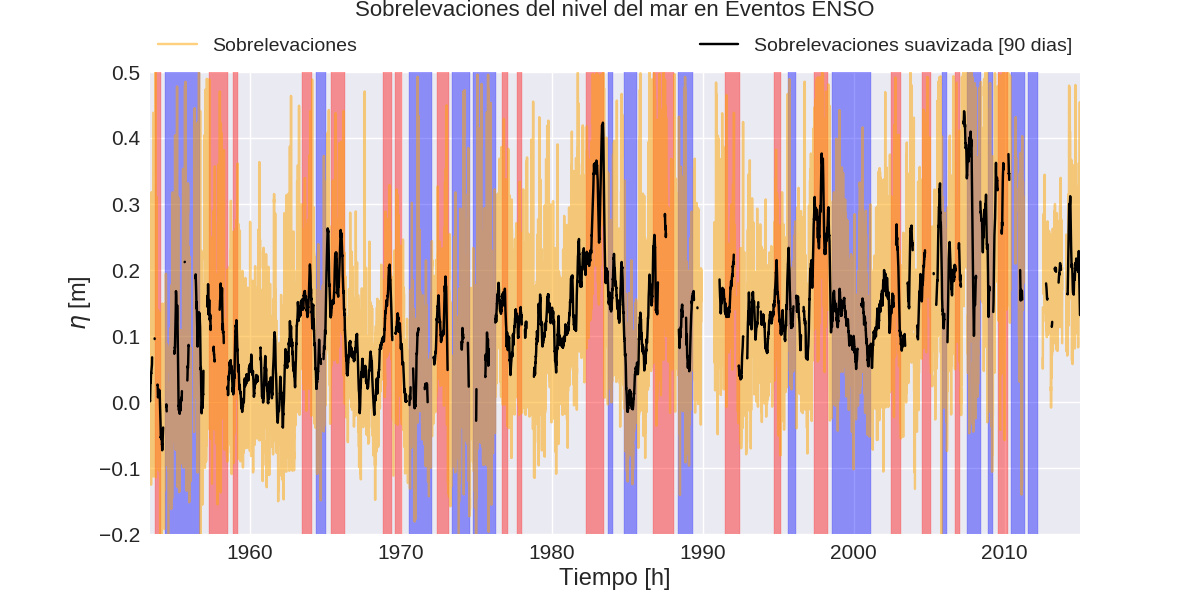

In [180]:
plot_final=converge_oni(serie_dif_maximos,serie_maximos_smoothed,Serie_oni,"on")

### Gráfica de serie suavizada vs ONI

Se le aplicó un factor al ONI para graficarlo a una escala menor, comparable con las sobrelevaciones. Recordar que las unidades del ONI no son sobrelevaciones

In [252]:
serie_dif=serie_maximos_smoothed[Serie_oni.index]
indx_ints=np.where(serie_dif<=1)
serie_def=serie_dif.iloc[indx_ints]
serie_oni_def=Serie_oni[serie_def.index]

len(serie_def),len(serie_oni_def)

(511, 511)

<IPython.core.display.Javascript object>


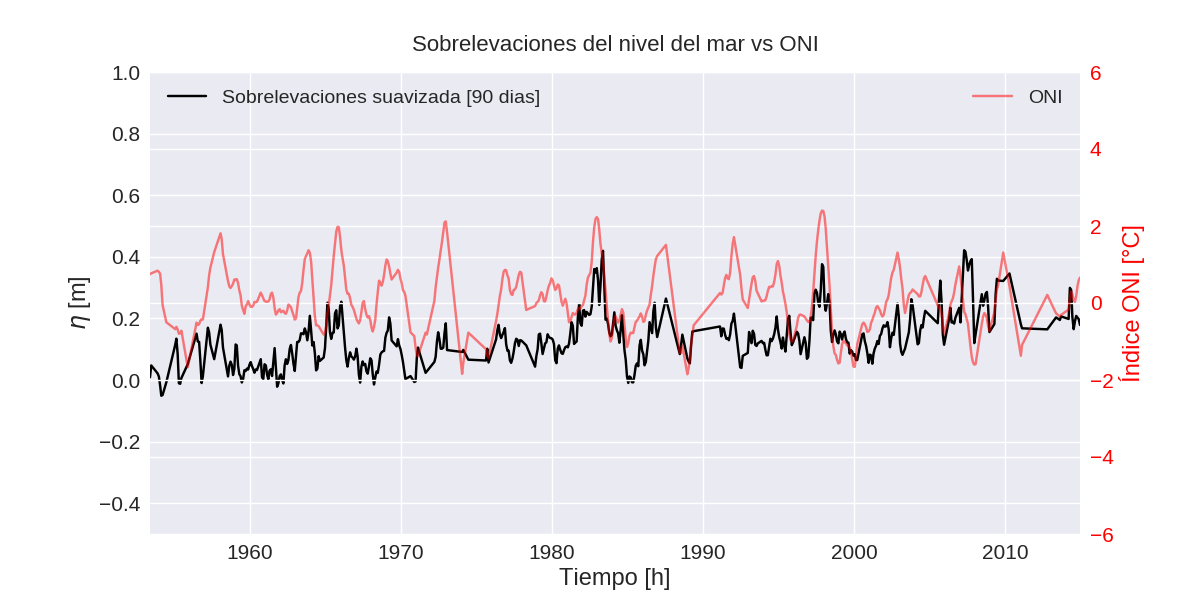

In [253]:
plot_final=converge_oni(serie_dif_maximos,serie_def,serie_oni_def,"off")

<IPython.core.display.Javascript object>


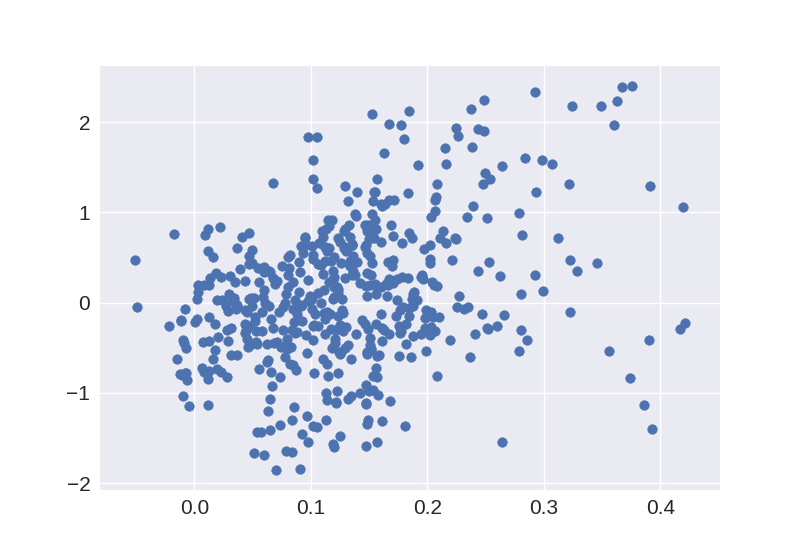

(SpearmanrResult(correlation=0.3080726255316615, pvalue=1.0719236857783415e-12),
 (0.33476818224174126, 7.577946171556718e-15))

In [202]:
plt.figure()
plt.scatter(serie_def,serie_oni_def)
sp.stats.spearmanr(serie_def,serie_oni_def),sp.stats.pearsonr(serie_def,serie_oni_def)

In [256]:
len(serie_maximos_smoothed),len(serie_oni_def)

(22514, 511)

<IPython.core.display.Javascript object>


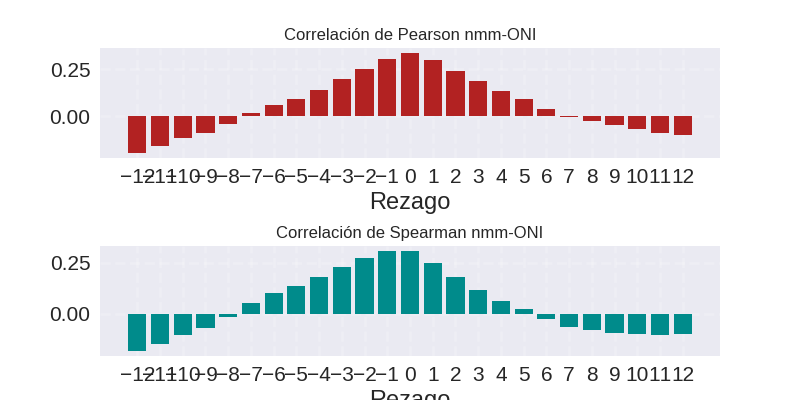

[-0.18396176761841423, -0.14807498552174167, -0.10450594713064379, -0.06935115515611873, -0.01577947620789274, 0.05276658268690127, 0.1004640191719124, 0.1342120011310744, 0.179233678956628, 0.22854820547985336, 0.2716042563912706, 0.30696751554597657, 0.3080726255316615, 0.24853191037761155, 0.17859275250791273, 0.11546408514691126, 0.061438260280056556, 0.02062424469925829, -0.028500462929239825, -0.06578242973071963, -0.08200504308460312, -0.09432667525153636, -0.10249448258047993, -0.10762104599401376, -0.10254603706782014]


(<matplotlib.axes._subplots.AxesSubplot at 0x7f5069dcea90>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f50689d60f0>)

In [257]:
correlation(serie_def,serie_oni_def,"ONI")

In [258]:
def converge_mei(serie_original,serie_smoothed,Serie_index,swich):
        fig,ax=plt.subplots(1,1,figsize=(12,6))
        ax.set_ylabel("$\eta$ [m]")
        ax.set_xlabel("Tiempo [h]")
        ax.set_xlim(serie_smoothed.index[0],serie_smoothed.index[-1])
        
        if swich=="on":
            ax.plot(serie_original,c='orange',alpha=0.5,label="Sobrelevaciones")
            ax.set_title("Sobrelevaciones del nivel del mar en Eventos ENSO",pad=40,fontsize=16)
            ax.set_ylim(-0.2,0.5)
            for i,k in zip(inicio_niño2,fin_niño2): #Niño y después niña
                ax.fill_betweenx([-3,3],Serie_index.index[locs_niño2[i]],Serie_index.index[locs_niño2[k]],\
                                 color="r",alpha=0.4)
            for j,m in zip(inicio_niña2,fin_niña2): #Niño y después niña
                ax.fill_betweenx([-3,3],Serie_index.index[locs_niña2[j]],Serie_index.index[locs_niña2[m]],\
                                 color="b",alpha=0.4) 
            ax.plot(serie_smoothed,c='k',label="Sobrelevaciones suavizada [90 dias]")
            ax.legend(prop={'size':14},mode="expand", borderaxespad=0, ncol=4,bbox_to_anchor=(0,1.02,1,0.05))
            plt.savefig("./Plots/sobreelev_ENSOS.png",dpi=400,box_inches="tight")

        else:
#             ax.plot(serie_original,c='orange',alpha=0.5,label="Sobrelevaciones")
            ax.plot(serie_smoothed[Serie_index.index],c='k',label="Sobrelevaciones suavizada [90 dias]")
            ax.set_title("Sobrelevaciones del nivel del mar vs ONI",pad=15,fontsize=16)
            ax.set_ylim(-0.5,1)
            ax2 = ax.twinx()
            ax2.plot(Serie_index,c='red',alpha=0.5,label="ONI")
            ax2.tick_params(axis='y', labelcolor='red')
            ax2.set_ylim(-6,6)
            ax.legend(prop={'size':14},loc='upper left')
            ax2.legend(prop={'size':14},loc='upper right')
            ax2.set_ylabel("Índice ONI [°C]",color="red")
            plt.savefig("./Plots/sobreelev_MEI.png",dpi=400,box_inches="tight")
        
        return fig

### Gráfica con sobrelevaciones y fases del ENSO [MEI]

<IPython.core.display.Javascript object>


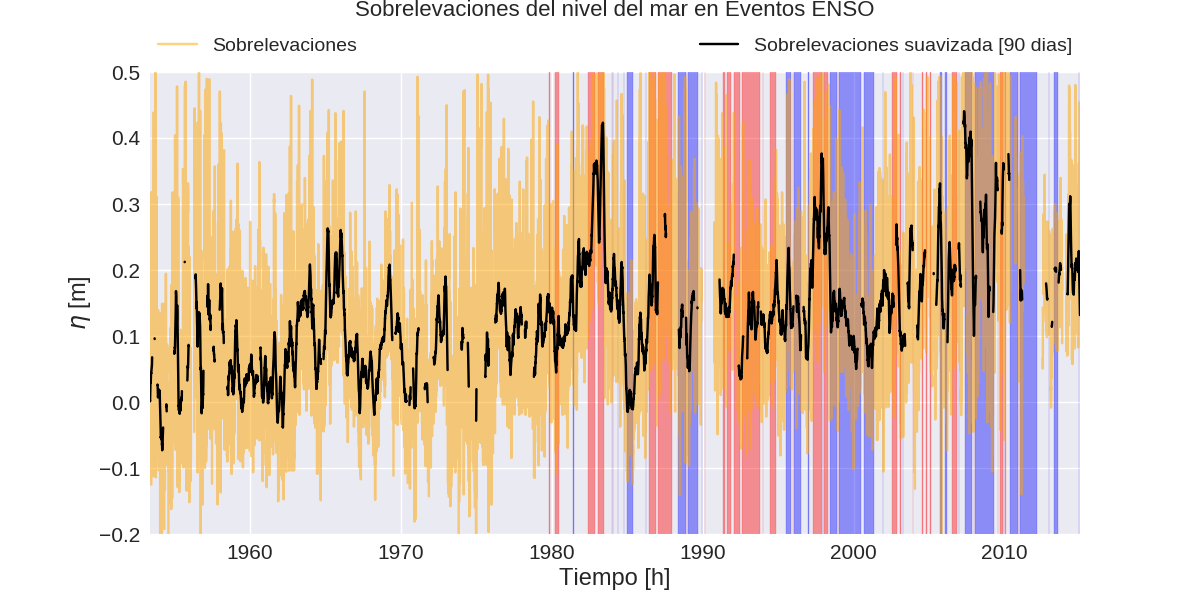

In [259]:
plot_final=converge_mei(serie_dif_maximos,serie_maximos_smoothed,Serie_mei,"on")

### Gráfica de serie suavizada vs MEI

In [260]:
serie_dif=serie_maximos_smoothed[Serie_mei.index]
indx_ints=np.where(serie_dif<=1)
serie_def=serie_dif.iloc[indx_ints]
serie_mei_def=Serie_mei[serie_def.index]

<IPython.core.display.Javascript object>


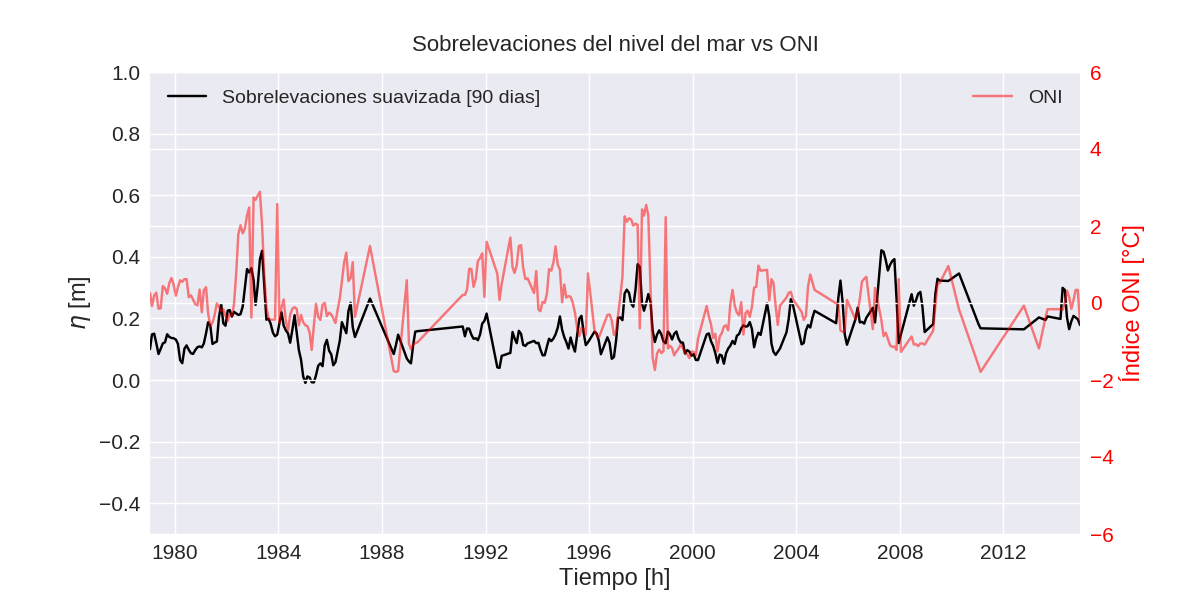

In [261]:
plot_final=converge_mei(serie_dif_maximos,serie_def,serie_mei_def,"off")

<IPython.core.display.Javascript object>


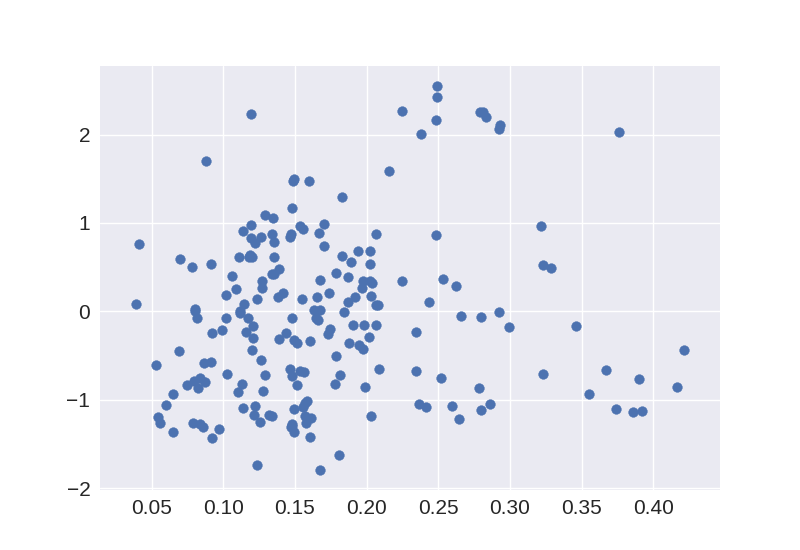

(SpearmanrResult(correlation=0.2160069362703624, pvalue=0.00016302699001077646),
 (0.2868453273487056, 4.322634074472875e-07))

In [262]:
plt.figure()
plt.scatter(serie_def[100:],serie_mei_def[100:])
sp.stats.spearmanr(serie_def,serie_mei_def),sp.stats.pearsonr(serie_def,serie_mei_def)

<IPython.core.display.Javascript object>


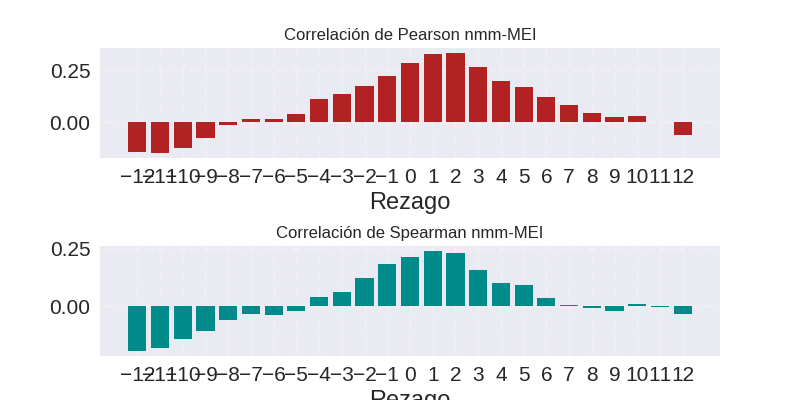

[-0.19551228196733123, -0.18323761629603696, -0.1449911094580968, -0.1103768981760572, -0.06071898006319502, -0.03287830892513718, -0.036495328357456495, -0.02115368794667579, 0.038581766121516696, 0.06213198877719213, 0.12464557250995062, 0.18295212559207938, 0.2160069362703624, 0.24080708314170773, 0.2322364253821307, 0.15796115006124833, 0.10094948213153296, 0.09380628311101193, 0.03410865123604304, 0.0068134335074327345, -0.006763897187995147, -0.02123062482508815, 0.008916024391246165, -0.0015929205522877792, -0.03211632520019534]


(<matplotlib.axes._subplots.AxesSubplot at 0x7f506cd0d588>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f506cc27cf8>)

In [263]:
correlation(serie_def,serie_mei_def,"MEI")

Papel, la trapera, jabón

## Duración de los eventos

<IPython.core.display.Javascript object>


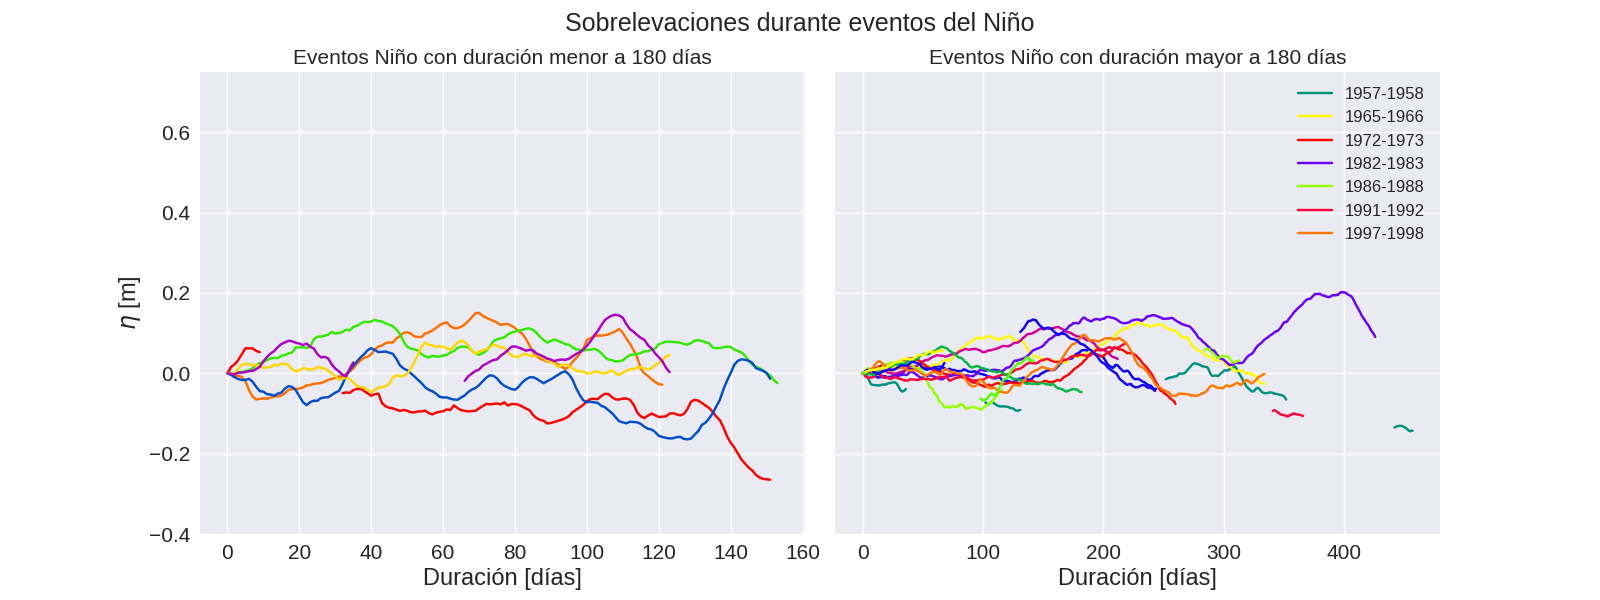

In [280]:
import matplotlib.cm as cm 
colors = cm.prism(np.linspace(0, 1, len(inicio_niño)))

fig,[ax180,ax360]=plt.subplots(1,2,sharey=True,figsize=[16,6])

serie_dif_maximos,serie_maximos_smoothed=smoothed(serie_max_residual,15)
serie_dif_maximos2,serie_maximos_smoothed2=smoothed(serie_max_residual,60)
durs=np.ones((len(inicio_niño),))
sob_max=np.ones((len(inicio_niño,)))

for i,k in zip(inicio_niño,fin_niño): #Niño y después niña
    a=Serie_oni.index[locs_niño[i]]
    b=Serie_oni.index[locs_niño[k]]
    duracion=(b-a).days+1
    serie_plot=serie_maximos_smoothed[a:b].values
    serie_plot2=serie_maximos_smoothed2[a:b].values
    ax180.set_ylabel("$\eta$ [m]")
    ax180.set_ylim(-0.4,0.75)
    
    if duracion<=180:
        ax180.plot(serie_plot-serie_plot[0],c=colors[inicio_niño.index(i)])
        ax180.set_xlabel("Duración [días]")
        ax180.set_title("Eventos Niño con duración menor a 180 días",fontsize=15)
        durs[inicio_niño.index(i)]=duracion
        sob_max[inicio_niño.index(i)]=np.nanmax(serie_plot)
    else:
        if duracion>300:
            ax360.plot(serie_plot2-serie_plot2[0],c=colors[inicio_niño.index(i)],label=str(a.year)+"-"+str(b.year))
        else:
            ax360.plot(serie_plot2-serie_plot2[0],c=colors[inicio_niño.index(i)])
        ax360.set_xlabel("Duración [días]")
        ax360.set_title("Eventos Niño con duración mayor a 180 días",fontsize=15)
        ax360.legend(prop={'size':12})
        durs[inicio_niño.index(i)]=duracion
        sob_max[inicio_niño.index(i)]=np.nanmax(serie_plot2)
    
plt.subplots_adjust(wspace=0.05)
plt.suptitle("Sobrelevaciones durante eventos del Niño",fontsize=18)
    
plt.savefig('./Plots/nino_events',dpi=600,bbox_inches="tight",pad_inches=0)

In [286]:
sob_max

array([0.16395979, 0.17958148, 0.17805113, 0.20845054, 0.26066075,
       0.20813781, 0.17774893, 0.19011481, 0.23708338, 0.18161178,
       0.42321642, 0.28490921, 0.22327642, 0.21508802, 0.37651905,
       0.26917472, 0.22990002, 0.32563964, 0.36200714])

<IPython.core.display.Javascript object>


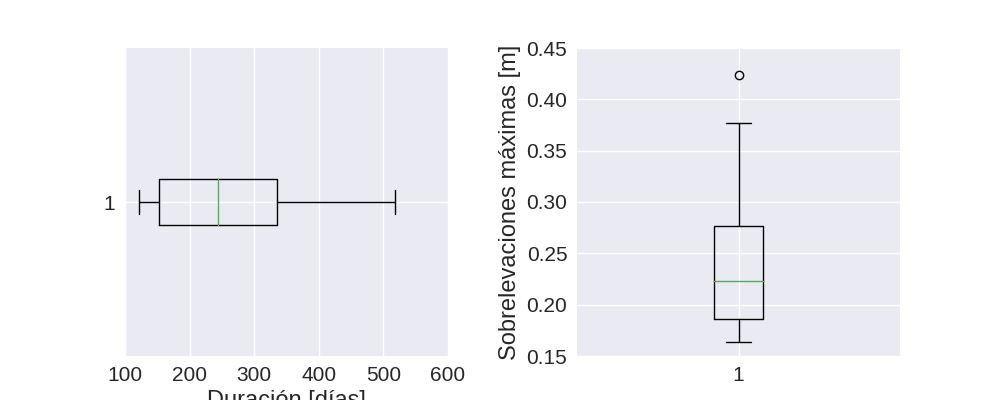

In [288]:
fig,[ax1,ax2]=plt.subplots(1,2,figsize=(10,4))

ax1.boxplot(durs,vert=False)
ax1.set_xlabel("Duración [días]")
ax1.set_xlim((100,600))

ax2.boxplot(sob_max)
ax2.set_ylabel("Sobrelevaciones máximas [m]")
ax2.set_ylim((0.15,0.45))

plt.subplots_adjust(wspace=0.4)
# plt.show()
# plt.ylabel("")

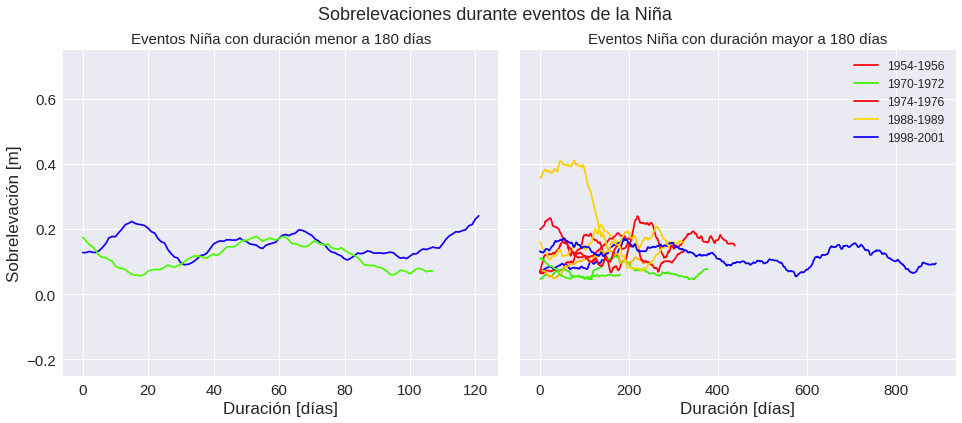

In [63]:
colors = cm.prism(np.linspace(0, 1, len(inicio_niña)))

fig,[ax180,ax360]=plt.subplots(1,2,sharey=True,figsize=[16,6])

serie_dif_maximos,serie_maximos_smoothed=smoothed(serie_max_residual,15)
serie_dif_maximos2,serie_maximos_smoothed2=smoothed(serie_max_residual,60)

for i,k in zip(inicio_niña,fin_niña): #Niño y después niña
    a=Serie_oni.index[locs_niña[i]]
    b=Serie_oni.index[locs_niña[k]]
    serie_plot=serie_maximos_smoothed[a:b].values
    serie_plot2=serie_maximos_smoothed2[a:b].values
    len_serie=len(serie_plot)
    ax180.set_ylabel("Sobrelevación [m]")
    ax180.set_ylim(-0.25,0.75)
    
    if len_serie<=180:
        ax180.plot(serie_plot,c=colors[inicio_niña.index(i)])
        ax180.set_xlabel("Duración [días]")
        ax180.set_title("Eventos Niña con duración menor a 180 días",fontsize=15)
    else:
        if len_serie>300:
            ax360.plot(serie_plot2,c=colors[inicio_niña.index(i)],label=str(a.year)+"-"+str(b.year))
        else:
            ax360.plot(serie_plot2,c=colors[inicio_niña.index(i)])
        ax360.set_xlabel("Duración [días]")
        ax360.set_title("Eventos Niña con duración mayor a 180 días",fontsize=15)
        ax360.legend(prop={'size':12})

    
plt.subplots_adjust(wspace=0.05)
plt.suptitle("Sobrelevaciones durante eventos de la Niña",fontsize=18)
    
plt.savefig('./Plots/nina_events',dpi=600,bbox_inches="tight",pad_inches=0)

In [28]:
serie_plot

array([], dtype=float64)

# Análisis espectral

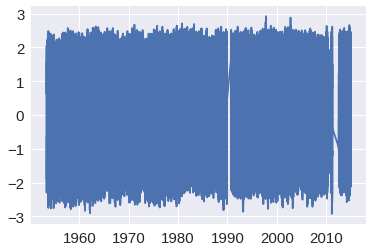

In [64]:
plt.figure()
plt.plot(serie_real)

In [65]:
fecha_inicio2,fecha_fin2

(datetime.datetime(1980, 1, 1, 0, 0), datetime.datetime(1986, 1, 1, 0, 0))

In [66]:
def T_fourier(serie):
    serie_trend=serie[fecha_inicio2:fecha_fin2].values
    serie_detrened=signal.detrend(serie_trend)
    fourier=np.fft.fft(serie_detrened)
    freq= np.fft.fftfreq(len(serie_detrened)) 
    pot = np.abs(fourier*1./len(fourier))
    periodos = 1/freq
    freq_pos=np.where(freq>=0)[0]
    
    return fourier,freq_pos,pot,periodos,freq

In [67]:
nmm_fourier,nmm_freq_pos,nmm_potencias,nmm_periodos,nmm_freq,=T_fourier(serie_real)

/home/franklin/my_projects_dir/entorno_jup/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


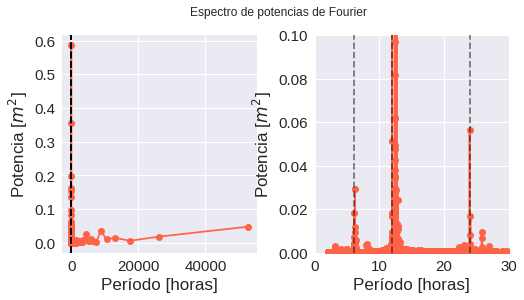

In [68]:
# %matplotlib notebook
plt.figure(figsize=(8,4))
plt.suptitle("Espectro de potencias de Fourier")
plt.subplot(121)
plt.plot(nmm_periodos[nmm_freq_pos],nmm_potencias[nmm_freq_pos],'-o',c="tomato")
# plt.xscale("log")
plt.axvline(x=6,ymin=0,ymax=1,ls="--",c='k')
plt.axvline(x=12,ymin=0,ymax=1,ls="--",c='k')
plt.axvline(x=24,ymin=0,ymax=1,ls="--",c='k')
plt.xlabel("Período [horas]")
plt.ylabel("Potencia [$m^{2}$]")
plt.savefig(".\Plots\Espectro de potencias.jpg",dpi=800,box_inches="tight",pad_inches=0)

plt.subplot(122)
plt.plot(nmm_periodos[nmm_freq_pos],nmm_potencias[nmm_freq_pos],'-o',c="tomato")
# plt.xscale("log")
plt.axvline(x=6,ymin=0,ymax=1,ls="--",c='k',alpha=0.5)
plt.axvline(x=12,ymin=0,ymax=1,ls="--",c='k',alpha=0.5)
plt.axvline(x=24,ymin=0,ymax=1,ls="--",c='k',alpha=0.5)
plt.xlabel("Período [horas]")
plt.ylabel("Potencia [$m^{2}$]")
plt.xlim(0,30)
plt.ylim(0,0.1)
plt.savefig(".\Plots\Espectro de potencias.jpg",dpi=800,box_inches="tight",pad_inches=0)

plt.subplots_adjust(wspace=0.3)

In [69]:
df_fourier=pd.DataFrame({"potencias":nmm_potencias[nmm_freq_pos],"p":nmm_periodos[nmm_freq_pos]})

In [70]:
# df_fourier[(round(df_fourier["p"],2)==11.96) | (round(df_fourier["p"],2)==11.97)]

In [71]:
test=df_fourier.sort_values(by="potencias")
# qgrid_widget = qgrid.show_grid(test, show_toolbar=True)

## Construyendo una componente

Para una primera aproximación, se intentará recrear el armónico $S_{2}$

In [72]:
index=np.where(round(df_fourier["p"],2)==11.97)[0][2] #Index 4384 con mayor potencia
amplitud_s2=nmm_potencias[index]*2 
fase_s2=np.angle(nmm_fourier[index])

In [73]:
t=np.arange(0,len(nmm_fourier))
s2_e=amplitud_s2*np.exp(1j*(nmm_freq[index]*2*np.pi*t+fase_s2))
s2=amplitud_s2*(np.cos(nmm_freq[index]*2*np.pi*t+fase_s2)+1j*np.sin(nmm_freq[index]*2*np.pi*t+fase_s2))

/home/franklin/my_projects_dir/entorno_jup/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


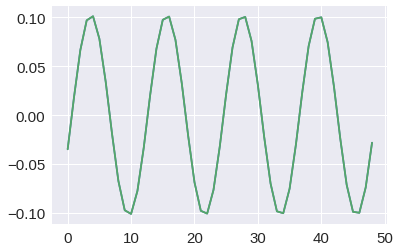

In [74]:
plt.figure()
plt.plot(s2[:49])
plt.plot(s2_e[:49])

In [75]:
n=len(nmm_fourier)

nmm_fourier_copy=np.copy(nmm_fourier)    
np.put(nmm_fourier_copy, range(0,index), 0.0)
np.put(nmm_fourier_copy, range(index+1, n), 0.0)
nmm_fourier_copy=nmm_fourier_copy*2
# Now fourier holds 1 imaginary coefficient
ifft = np.fft.ifft(nmm_fourier_copy)

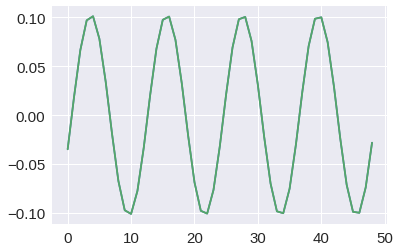

In [76]:
plt.figure()
plt.plot(ifft[:49])
plt.plot(s2[:49])

## Construyendo diversas componentes

In [77]:
index=test[test.p<=3].index

In [78]:
test.p[index]

26203    2.007747
20546    2.560547
18773    2.802376
25269    2.081958
23131    2.274394
           ...   
19129    2.750222
18980    2.771812
21099    2.493436
21327    2.466779
21178    2.484134
Name: p, Length: 8768, dtype: float64

### Obteniendo la sumatoria de las componente armónicas

In [79]:
suma_total=np.zeros((len(nmm_fourier),))*1j
t=np.arange(0,len(nmm_fourier))
for ix in index:
    amplitud=nmm_potencias[ix]*2 
    fase=np.angle(nmm_fourier[ix])
    suma_total+=amplitud*np.exp(1j*(nmm_freq[ix]*2*np.pi*t+fase))
#     suma_total+=amplitud*(np.cos(nmm_freq[ix]*2*np.pi*t+fase)+1j*np.sin(nmm_freq[ix]*2*np.pi*t+fase))

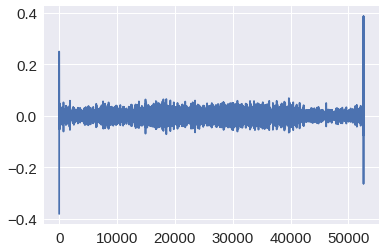

In [80]:
plt.figure()
plt.plot(suma_total)

In [ ]:
# n=len(nmm_fourier)
# suma=np.zeros((len(nmm_fourier),))*1j
# for i in index:
#     nmm_fourier_copy=np.copy(nmm_fourier)    
#     np.put(nmm_fourier_copy, range(0,i), 0.0)
#     np.put(nmm_fourier_copy, range(i+1, n), 0.0)
# # Now fourier holds 1 imaginary coefficient
#     ifft = np.fft.ifft(nmm_fourier_copy*2)
#     suma+=ifft

In [ ]:
# plt.figure()
# plt.plot(suma)

Sólo queda elegir los períodos a través de los cuales se quiere filtrar, extender el vector t dentro del ciclo y restar el valor obtenido al registro inicial.

In [ ]:
serie_real=serie_real.rolling(30).mean()

<center><font size="6"> Análisis del Satelite Aviso<font size> <center>
    
***

# Revisando evento por evento

## Función identificadora de eventos

In [20]:
def hovmollers(a,b,intensidad):
    idx_a=(a-1)-1993
    idx_b=(b+1)-1993
    fig,ax=plt.subplots(figsize=(12,10))
    xlocs=np.arange(-120, -60, 10)
    ylocs=np.arange(-3,10,2)
    ax.invert_yaxis()  # Reverse the time order to do oldest first
    ax.set_title('Diagrama de Hovmoller del Niño '+ str(a)+'-'+str(b) + ' '+ intensidad,fontsize=18)
    x,y=np.meshgrid(new_lon,new_array)
    cf=ax.contourf(x,y,sla_copy_mod[:,:],20,cmap="jet")
    cr=ax.contour(x,y,sla_copy_mod[:,:],20,colors="k",linewidths=0.3)
    cbar = plt.colorbar(cf, orientation='horizontal', pad=0.08, aspect=50)
    cbar.set_label('m',fontsize=15)
    cbar.ax.tick_params(labelsize=15) 

    ax.set_xticks(np.array(xlocs)+360)
    ax.set_xticklabels(x_tick_labels)
    ax.set_xlim((new_lon[0],new_lon[-4]))
    ax.tick_params(labelsize=15)
#     ax.grid(True,color='k',lw=3)
#     ax3=ax.twinx()
    
    #Linea alrededor de 92°W
    ax.axvline(x=new_lon[26],c='k',ls='--',lw=3)
    
    #Intervalo de visualización
    ax.set_ylim((new_array[365*idx_b],new_array[365*idx_a]))

    
    plt.savefig('./Plots/hovmoller_'+str(a)+'_'+str(b)+'.png',dpi=600,bbox_inches="tight")
    
    fig2,ax2=plt.subplots(figsize=(7.5,2))
    ax2.plot(serie_maximos_smoothed, 'k')
    for i,k in zip(inicio_niño,fin_niño): #Niño y después niña
        ax2.fill_betweenx([-3,3],Serie_oni.index[locs_niño[i]],Serie_oni.index[locs_niño[k]],color="r",alpha=0.4)
    for j,m in zip(inicio_niña,fin_niña): #Niño y después niña
        ax2.fill_betweenx([-3,3],Serie_oni.index[locs_niña[j]],Serie_oni.index[locs_niña[m]],color="b",alpha=0.4) 
    ax2.set_ylabel("nmm [m]")
    ax2.set_ylim((-0.2,0.5))
    ax2.set_xlim((new_array[365*idx_a],new_array[365*idx_b]))
#     ax2.tick_params(axis='x', labelsize=0, length = 5)
#     ax2.grid(True,color='k',lw=3)
    
    plt.savefig('./Plots/serie_'+str(a)+'_'+str(b)+'.png',dpi=600,bbox_inches="tight")
    
    return fig,fig2

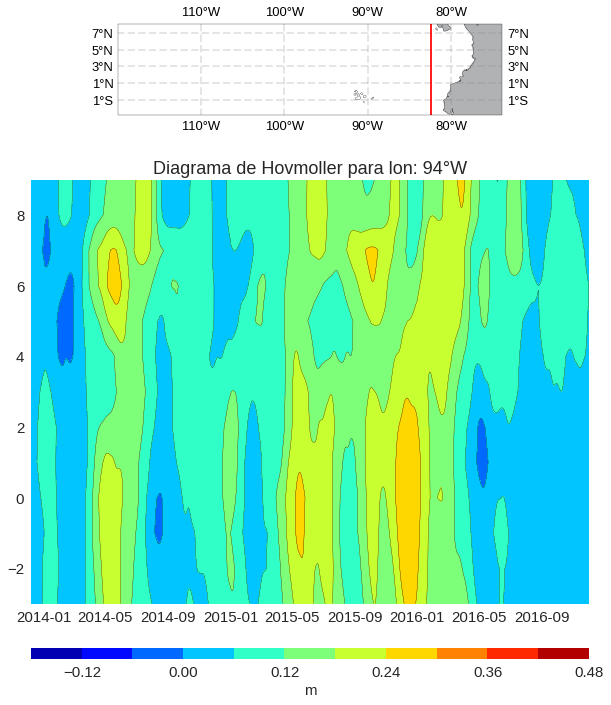

In [23]:
idx_a=(2015-1)-1993
idx_b=(2016+1)-1993
fig=plt.figure(figsize=(10,13))

gs = gsa.GridSpec(nrows=2, ncols=1,height_ratios=[1,6],hspace=0.2)

x_tick_labels = [u'120\N{DEGREE SIGN}W', u'110\N{DEGREE SIGN}W',
                 u'100\N{DEGREE SIGN}W', u'90\N{DEGREE SIGN}W',
                 u'80\N{DEGREE SIGN}W']

y_tick_labels = [u'-2\N{DEGREE SIGN}N', u'0\N{DEGREE SIGN}N',
                 u'2\N{DEGREE SIGN}N', u'4\N{DEGREE SIGN}N',
                 u'6\N{DEGREE SIGN}N',u'8\N{DEGREE SIGN}N']

xlocs=np.arange(-120, -60, 10)
ylocs=np.arange(-3,10,2)

# Acerca del primer subplot
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax1.set_extent([lon[0], lon[-1], lat[0],lat[-1]], ccrs.PlateCarree())
ax1.coastlines('50m')
ax1.add_feature(cartopy.feature.LAND, zorder=0,facecolor='#B1B2B4')
ax1.plot([lon[150],lon[150]],[lat[0],lat[-1]],color='red',transform=ccrs.PlateCarree())

gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.2, linestyle='--',
                   xlocs=xlocs,ylocs=ylocs)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 13, 'color': 'black'}
gl.ylabel_style = {'size': 13, 'color': 'black'}

# plt.title('CMEMS Reanalysis',y=1.3, loc='right',fontsize=18)

# Acerca del segundo subplot
ax2 = fig.add_subplot(gs[1, 0])
ax2.set_title('Diagrama de Hovmoller para lon: '+str(360-new_lon[26])+"°W",fontsize=18)

x,y=np.meshgrid(new_array,new_lat)
cf=ax2.contourf(x,y,sla_copy_mod2[:,:],10,cmap="jet")
cr=ax2.contour(x,y,sla_copy_mod2[:,:],10,colors="k",linewidths=0.3)
cbar = plt.colorbar(cf, orientation='horizontal', pad=0.08, aspect=50)
cbar.set_label('m',fontsize=15)
cbar.ax.tick_params(labelsize=15) 

# ax2.set_xticks(np.array(xlocs)+360)
# ax2.set_xticklabels(x_tick_labels)
# ax2.set_xlim((new_array[365],new_array[-1]))
ax2.set_xlim((new_array[365*idx_a],new_array[365*idx_b]))


ax2.tick_params(labelsize=15)

# Eventos Niño

## Niño 1994-1995 (moderado)

NameError: name 'serie_maximos_smoothed' is not defined

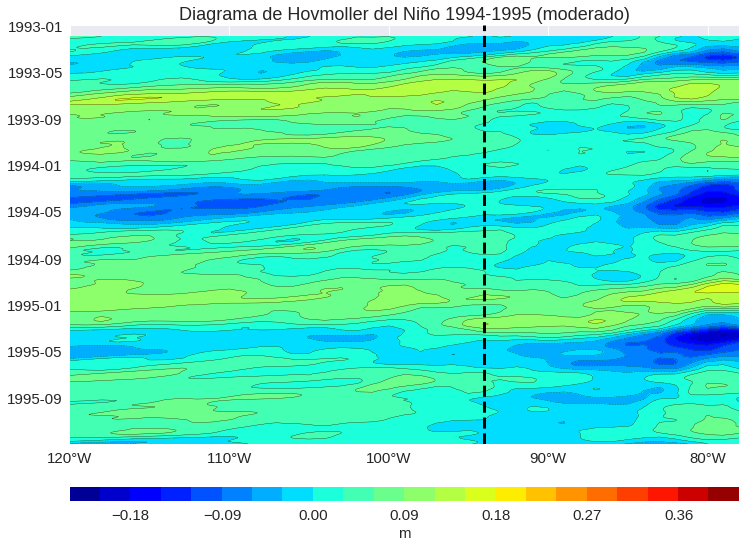

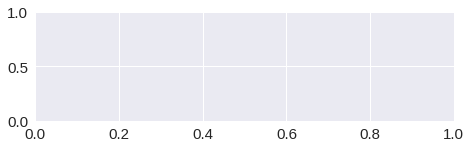

In [22]:
hovmollers(1994,1995,'(moderado)')

Tuvo cerca a la costa, anomalías alrededor de los 12 cm, su intensidad fue moderada, empezó en Septiembre y acabó en marzo y duró cerca de 6 meses.

Las anomalías son cercanas a 20 cm según los datos del mareógrafo.

## Niño 1997-1998 (very strong) 

<IPython.core.display.Javascript object>


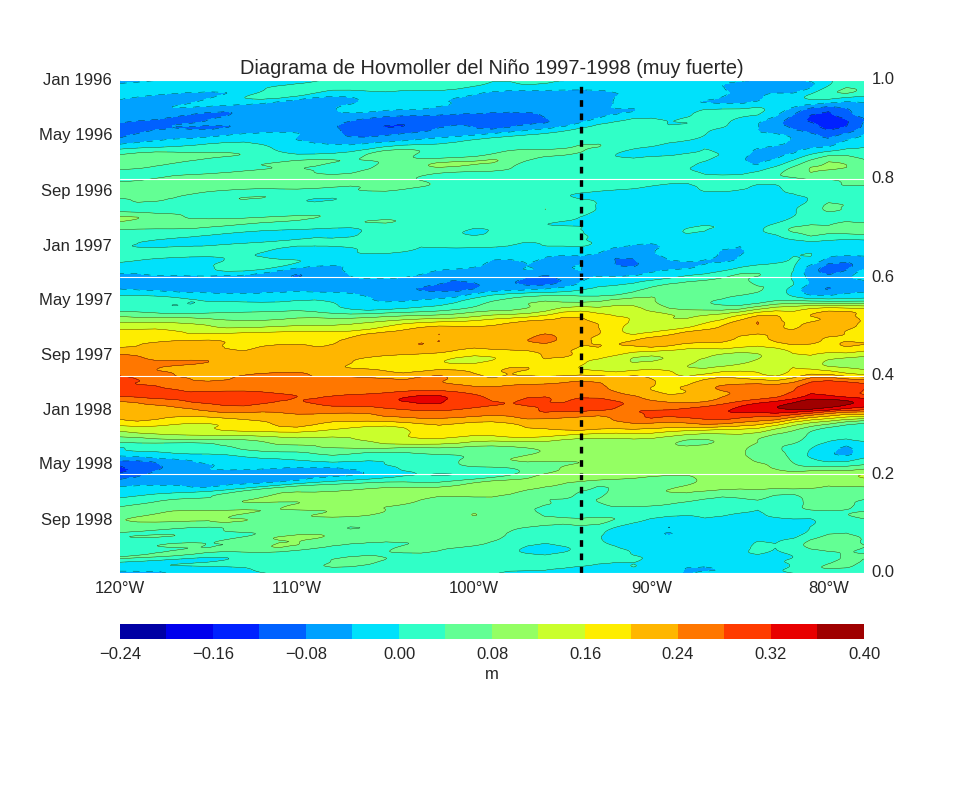

<IPython.core.display.Javascript object>


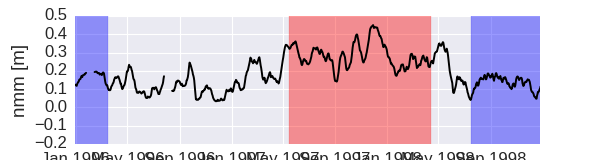

(<Figure size 960x800 with 3 Axes>, <Figure size 600x160 with 1 Axes>)

In [362]:
hovmollers(1997,1998,'(muy fuerte)')

Tuvo cerca a la costa, anomalías alrededor de los 30 cm, su intensidad fue muy fuerte, empezó en Mayo y acabó en Abril y duró cerca de 11 meses.

Las anomalías son cercanas a 30 cm según los datos del mareógrafo.

## Niño 2002-2003 (moderado)

(<Figure size 864x720 with 2 Axes>, <Figure size 720x144 with 1 Axes>)

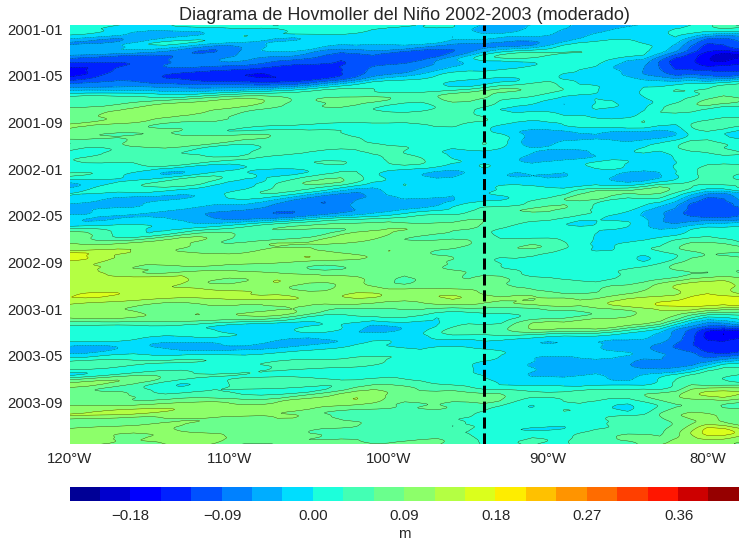

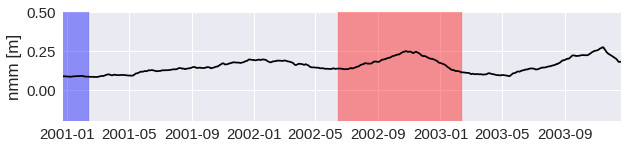

In [129]:
hovmollers(2002,2003,'(moderado)')

Tuvo cerca a la costa, anomalías alrededor de los 18 cm, su intensidad fue moderada, empezó en Junio y acabó en Febrero y duró cerca de 7 meses.

Las anomalías que registra son...

## Niño 2004-2005 (weak)

(<Figure size 864x720 with 2 Axes>, <Figure size 720x144 with 1 Axes>)

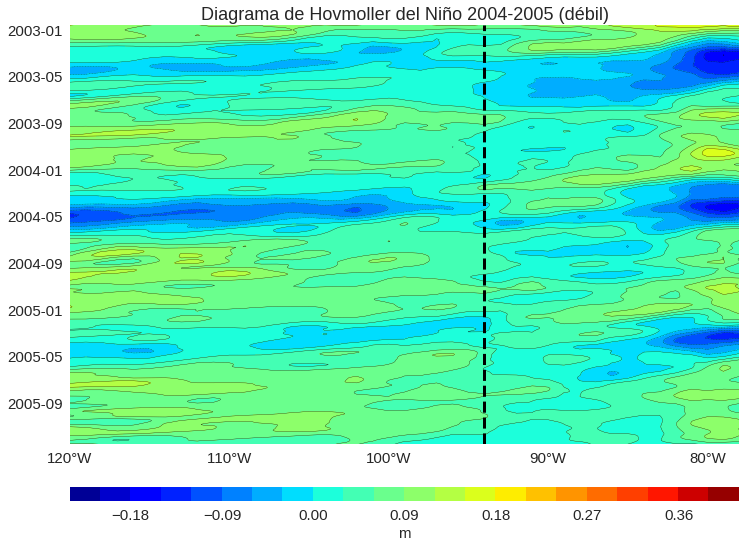

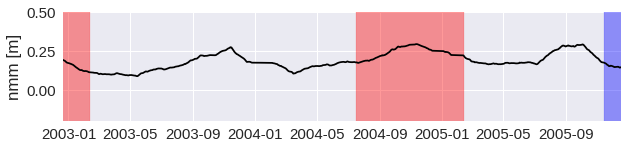

In [130]:
hovmollers(2004,2005,'(débil)')

Tuvo cerca a la costa, anomalías alrededor de los 10-11 cm, su intensidad fue débil, empezó en Julio y acabó en Febrero y duró cerca de 6 meses.

Las anomalías que registra son...

## Niño 2006-2007 (weak)

(<Figure size 864x720 with 2 Axes>, <Figure size 720x144 with 1 Axes>)

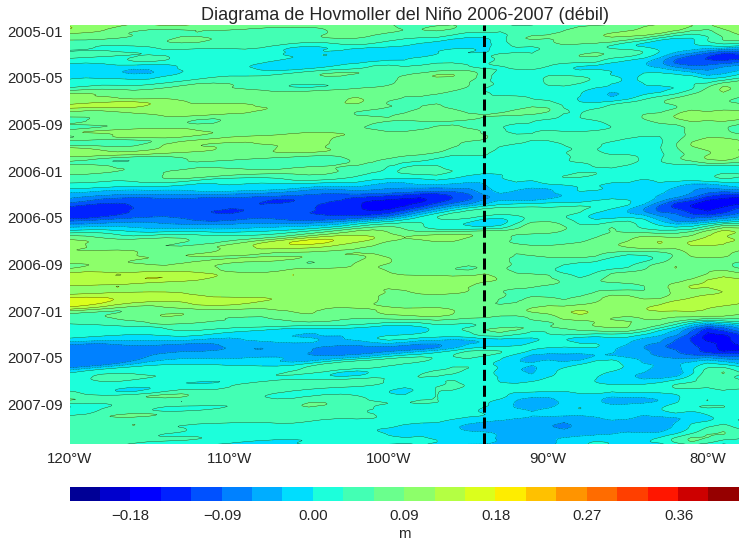

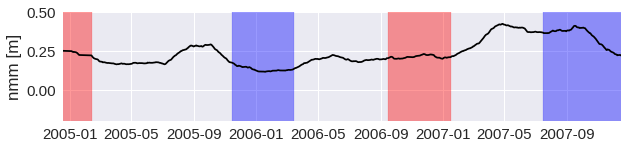

In [131]:
hovmollers(2006,2007,'(débil)')

Tuvo cerca a la costa, anomalías alrededor de los 10-11 cm, su intensidad fue débil, empezó en Julio y acabó en Febrero y duró cerca de 4 meses.

Las anomalías que registra son...

In [132]:
# for i,k in zip(inicio_niño,fin_niño): #Niño y después niña
#     a=Serie_oni.index[locs_niño[i]]
#     b=Serie_oni.index[locs_niño[k]]
#     print(a,b)

## Niño 2009-2010 (moderate)

(<Figure size 864x720 with 2 Axes>, <Figure size 720x144 with 1 Axes>)

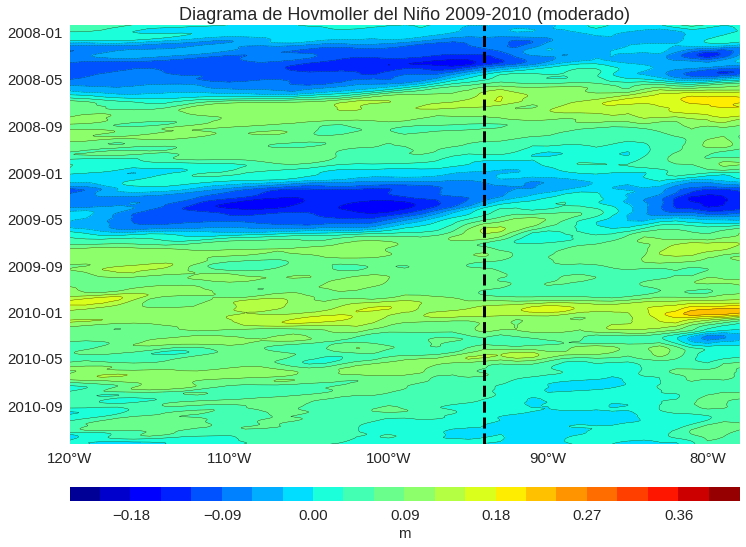

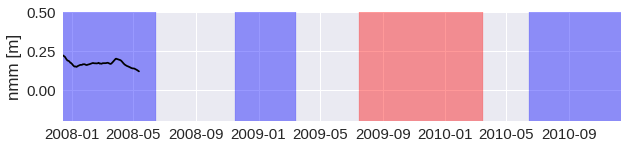

In [133]:
hovmollers(2009,2010,'(moderado)')

Tuvo cerca a la costa, anomalías alrededor de los 21-23 cm, su intensidad fue moderada, empezó en Julio y acabó en Febrero y duró cerca de 8 meses.

Las anomalías que registra son...

## Niño 2014-2015 (weak)

(<Figure size 864x720 with 2 Axes>, <Figure size 720x144 with 1 Axes>)

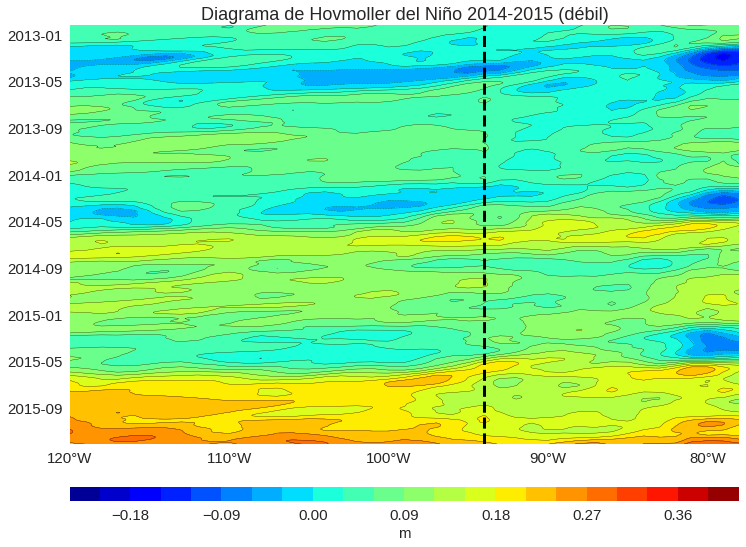

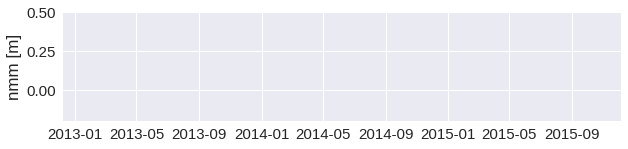

In [134]:
hovmollers(2014,2015,'(débil)')

## Niño 2015-2016 (Very strong)

(<Figure size 864x720 with 2 Axes>, <Figure size 720x144 with 1 Axes>)

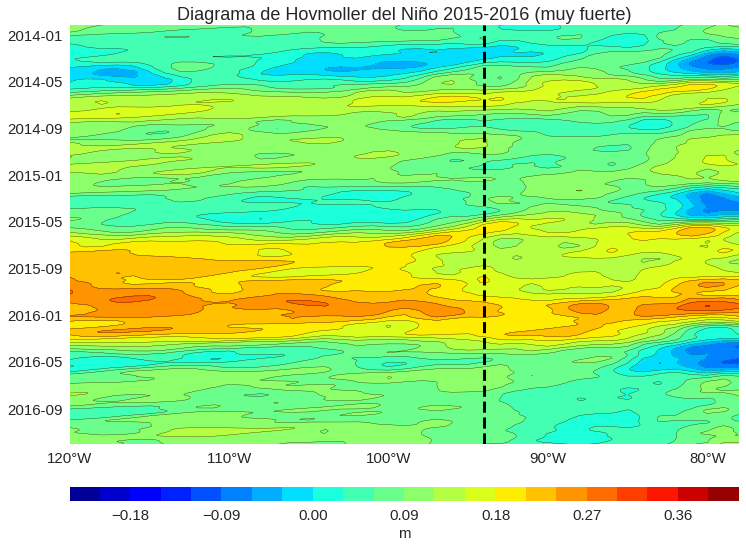

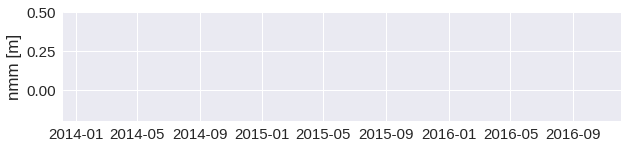

In [135]:
hovmollers(2015,2016,'(muy fuerte)')

Tuvo cerca a la costa, anomalías alrededor de los 30 cm, su intensidad fue muy fuerte, empezó en Julio y acabó en Febrero y duró cerca de 8-9 meses.

Las anomalías que registra son...

## Tareas para hacer con estos eventos

1. Empalmar las imágenes para que queden adyacentes
2. Dibujar la flecha que indique el movimiento de la anomalía

# Otras correlaciones

In [216]:
data=pd.DataFrame(serie_max_residual,columns=["Data"])
data["Year"]=data.index.year
data["Month"]=data.index.month
data_group=data.groupby(["Year","Month"]).mean()

<IPython.core.display.Javascript object>


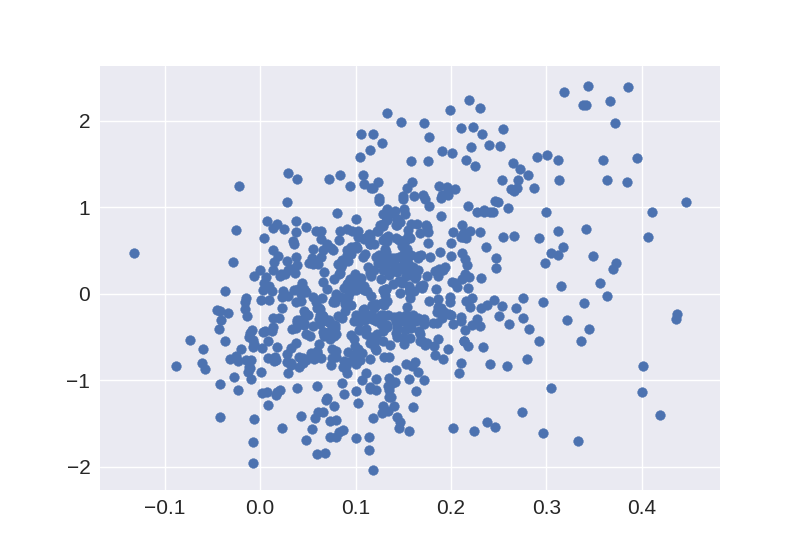

In [220]:
plt.figure()
plt.scatter(data_group.values.ravel(),Serie_oni.values)

In [214]:
plt.plot(data_group.values)
plt.plot(Serie_oni.values/rate)

NameError: name 'rate' is not defined

<IPython.core.display.Javascript object>


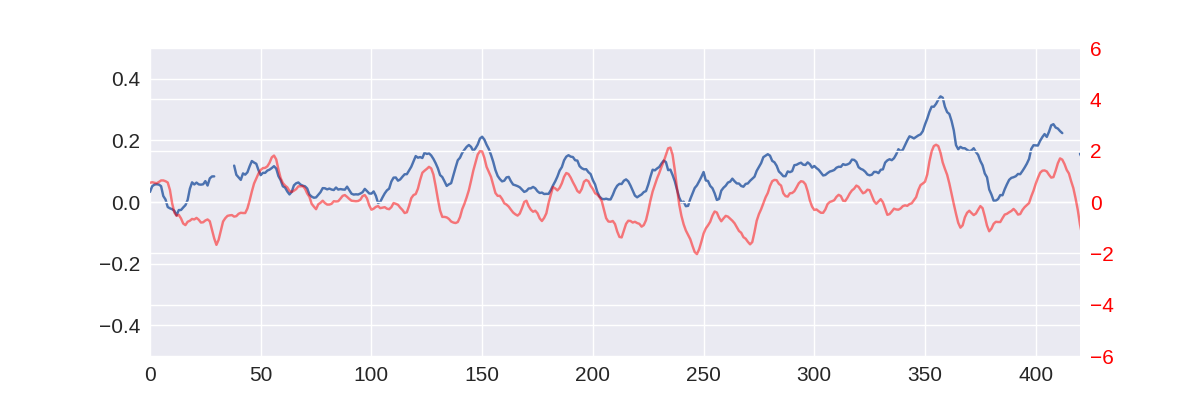

(0, 420)

In [237]:
fig,ax=plt.subplots(figsize=(12,4))
marea=smooth(data_group.values.ravel(),7)
ax.plot(marea)
ax.set_ylim(-0.5,0.5)
ax2 = ax.twinx()
ax2.plot(Serie_oni.values,c='red',alpha=0.5,label="ONI")
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(-6,6)
ax.set_xlim((0,420))

In [221]:
def correlation (serie1,serie2,b):
    
    corr=[pearsonr(serie1[:-i],serie2[i:])[0] for i in range(1,13)[::-1]]
    corr=corr+[pearsonr(serie1,serie2)[0]]+[pearsonr(serie1[i:],serie2[:-i])[0]
        for i in range(1,13)]
    
    corr2=[spearmanr(serie1[:-i],serie2[i:])[0] for i in range(1,13)[::-1]]
    corr2=corr2+[spearmanr(serie1,serie2)[0]]+[spearmanr(serie1[i:],serie2[:-i])[0] for i in range(1,13)]
    
    
    fig=plt.figure(figsize=(8,4))
    ax=fig.add_subplot(211)
    ax.bar(range(-12,13),corr,color='firebrick')
    ax.set_title('Correlación de Pearson nmm-'+b)
#     ax.set_ylabel(u'Pearson')
    ax.set_xlabel('Rezago')
    ax.set_xticks(range(-12,13))
    ax.grid(linestyle='--',lw=2,alpha=.2)
    
    ax2=fig.add_subplot(212)
    ax2.bar(range(-12,13),corr2,color='darkcyan')
    ax2.set_title('Correlación de Spearman nmm-'+b)
#     ax2.set_ylabel(u'Spearman')
    ax2.set_xlabel('Rezago')
    ax2.set_xticks(range(-12,13))
    ax2.grid(linestyle='--',lw=2,alpha=.2)
    
    plt.subplots_adjust(hspace=0.8)
    plt.savefig(".\Plots\Rezagos con "+b)
#    
    print(corr2)
    return ax,ax2

In [238]:
nomas=smooth(data_group.values.ravel(),4)

<IPython.core.display.Javascript object>


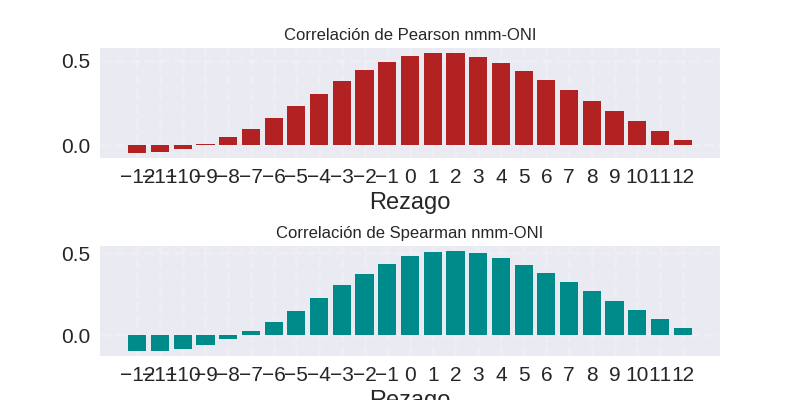

[-0.09439574825884081, -0.09196814824679596, -0.08142230154785766, -0.05739038972099028, -0.021207085814313967, 0.025681200633950463, 0.0837881893950402, 0.1518026857012036, 0.22788992623394197, 0.3046977971750974, 0.3748464687360478, 0.435326948181702, 0.48108772259693766, 0.5076272473740866, 0.5141431096711819, 0.5016212555248407, 0.47197496899073865, 0.42921571118226465, 0.37866185179324047, 0.32454379160741614, 0.26837386155482934, 0.21077716826715248, 0.15305509783198917, 0.0984458975354136, 0.047878918372624125]


(<matplotlib.axes._subplots.AxesSubplot at 0x7f5069031240>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f50691dd1d0>)

In [239]:
correlation(Serie_oni.values[50:400],marea[50:400],"ONI")

<IPython.core.display.Javascript object>


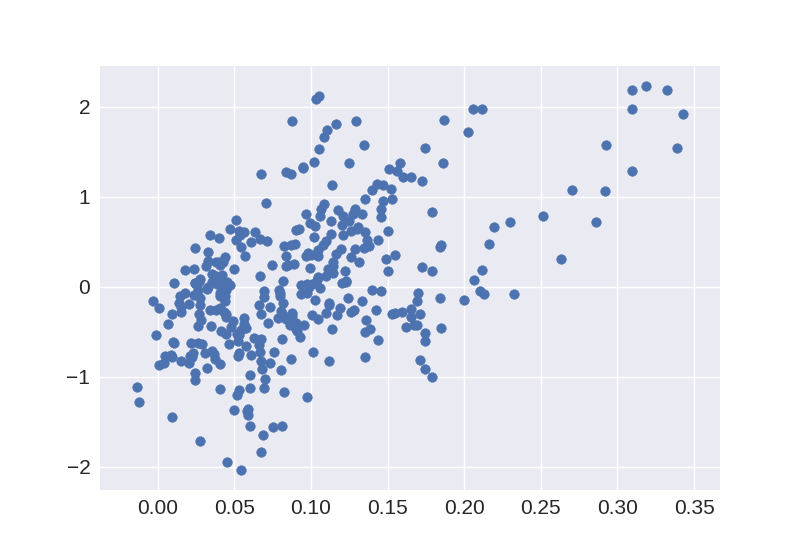

In [244]:
plt.figure()
plt.scatter(marea[50:400],Serie_oni.values[50:400])

In [241]:
a,b=[],[]
for i,k in zip(inicio_niño2,fin_niño2):
    a+=Serie_mei[locs_niño2[i]:locs_niño2[k]].values.tolist()
    b+=marea[locs_niño2[i]:locs_niño2[k]].tolist()

<IPython.core.display.Javascript object>


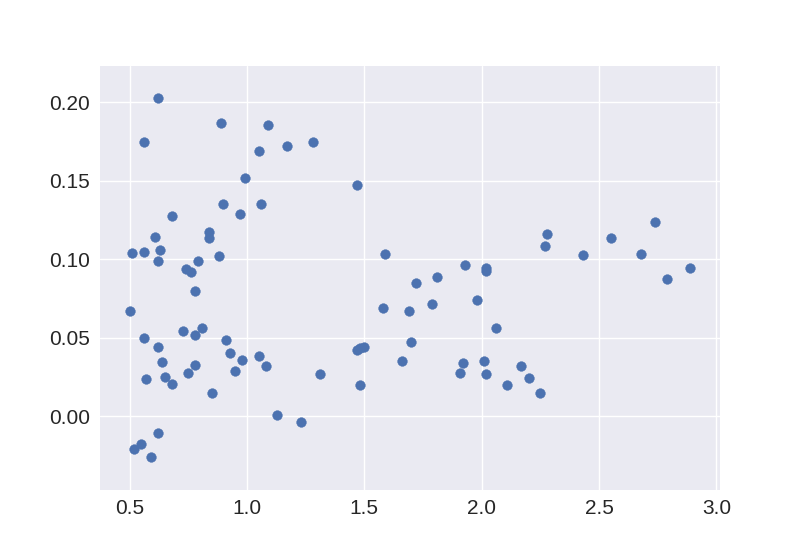

In [243]:
plt.figure()
plt.scatter(a,b)

In [336]:
spearmanr(a,b)

SpearmanrResult(correlation=0.017892493319526658, pvalue=0.8716656270272483)

In [25]:
time

array([15706., 15707., 15708., ..., 25332., 25333., 25334.], dtype=float32)

# Evolución de la sla en el Niño 97-98

In [108]:
idx_years=[i for i in range(len(date)) if date[i] in dates_year]
idx_year=[idx_years[i] for i in range(len(idx_years)) if i%2!=0]

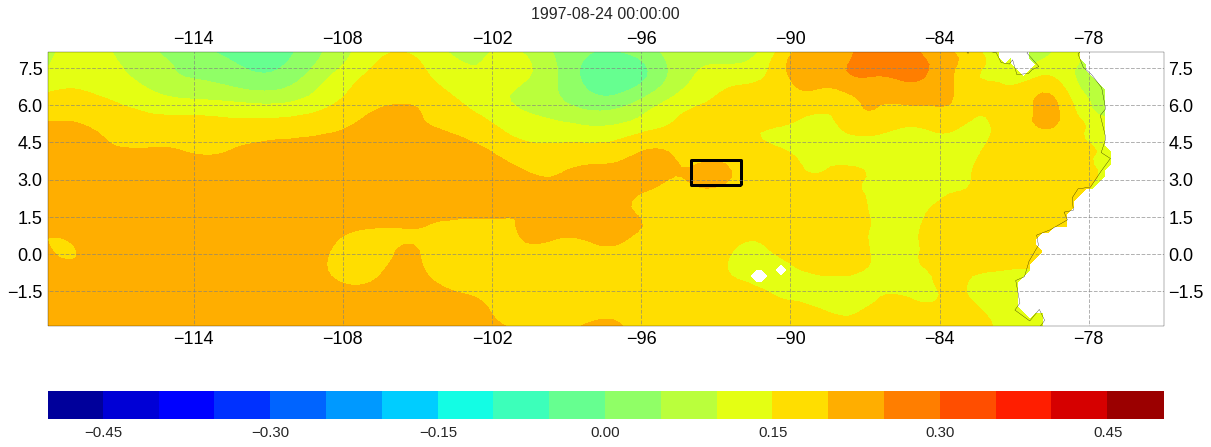

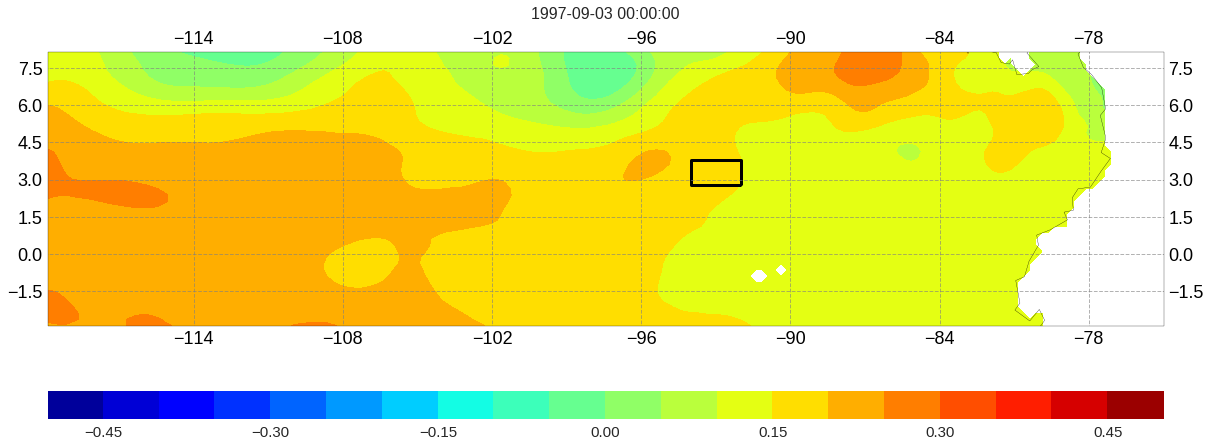

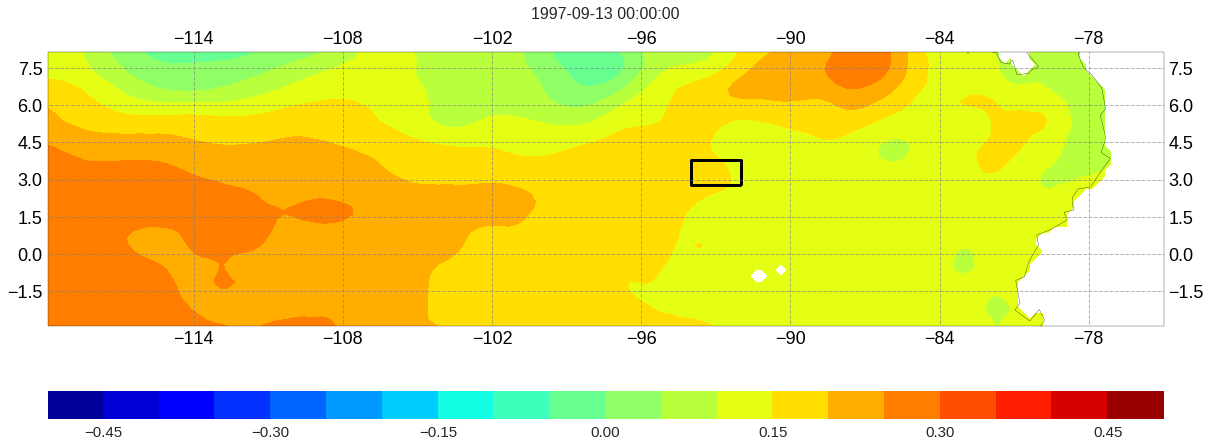

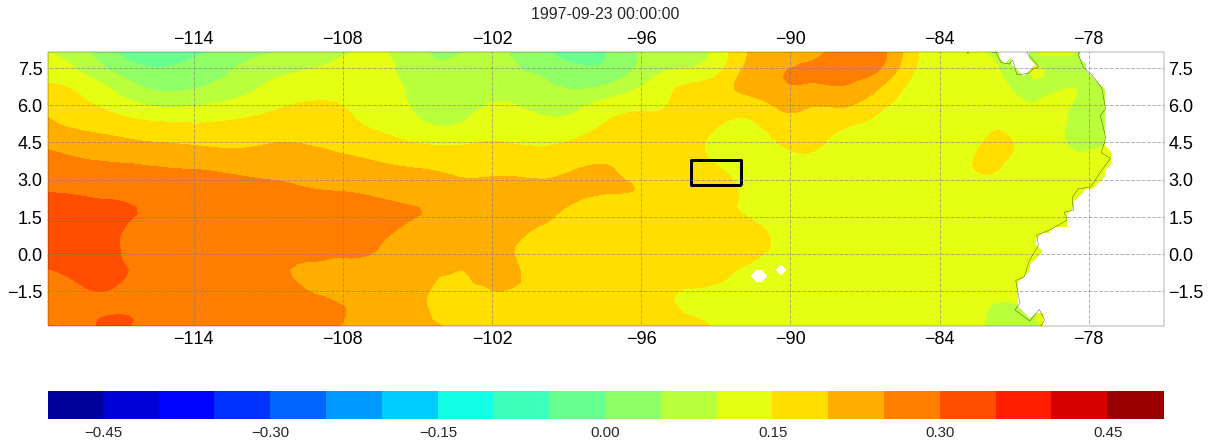

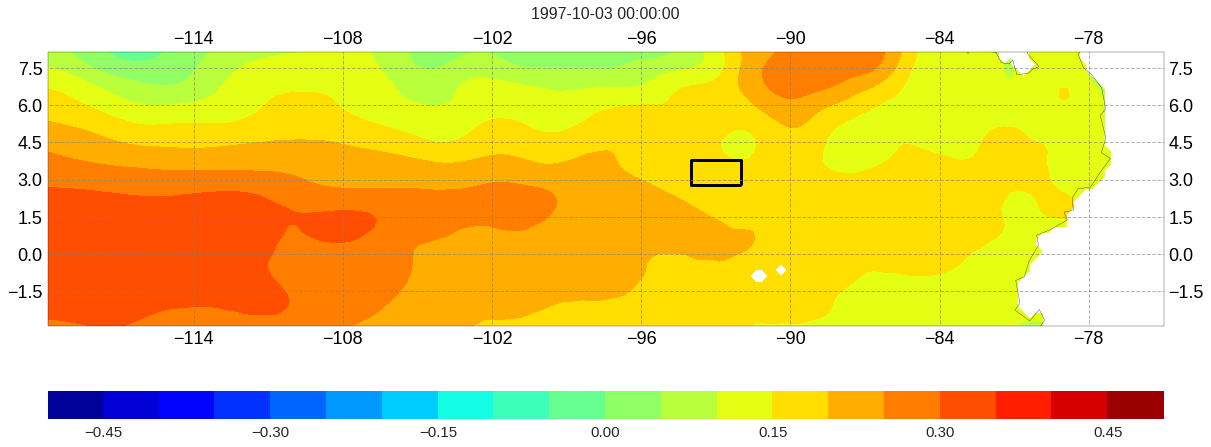

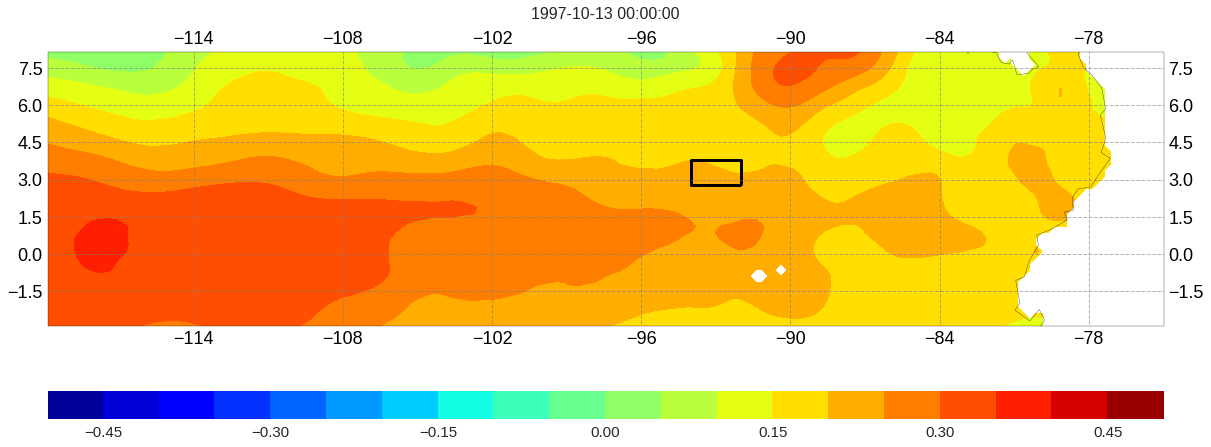

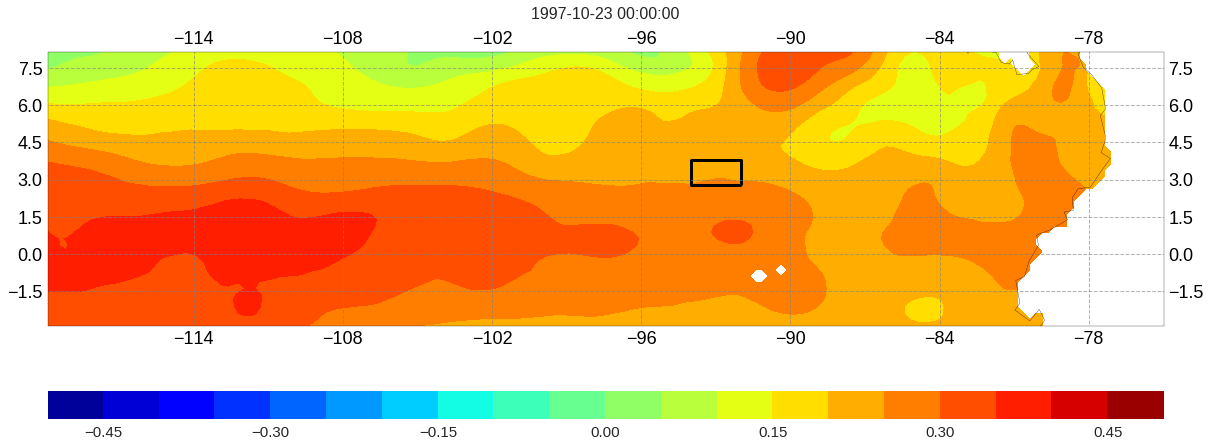

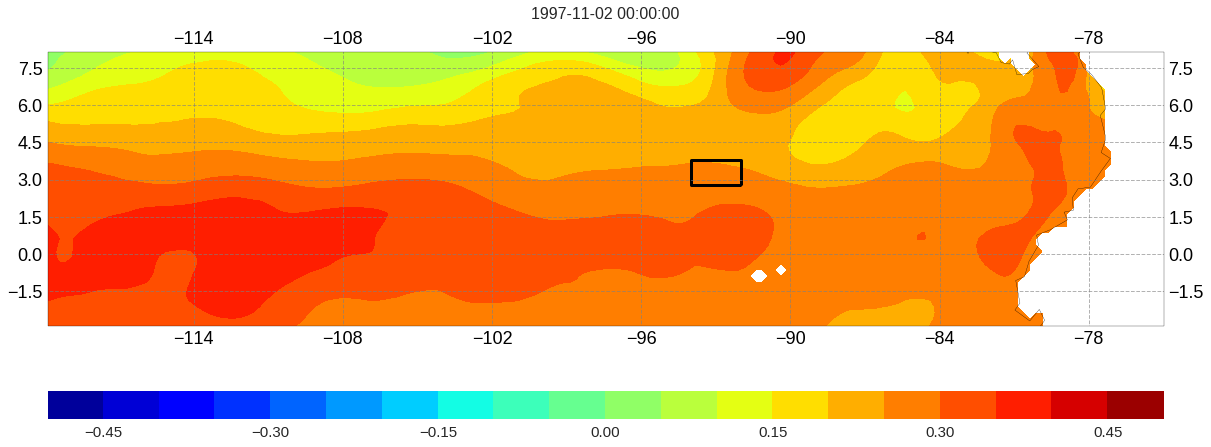

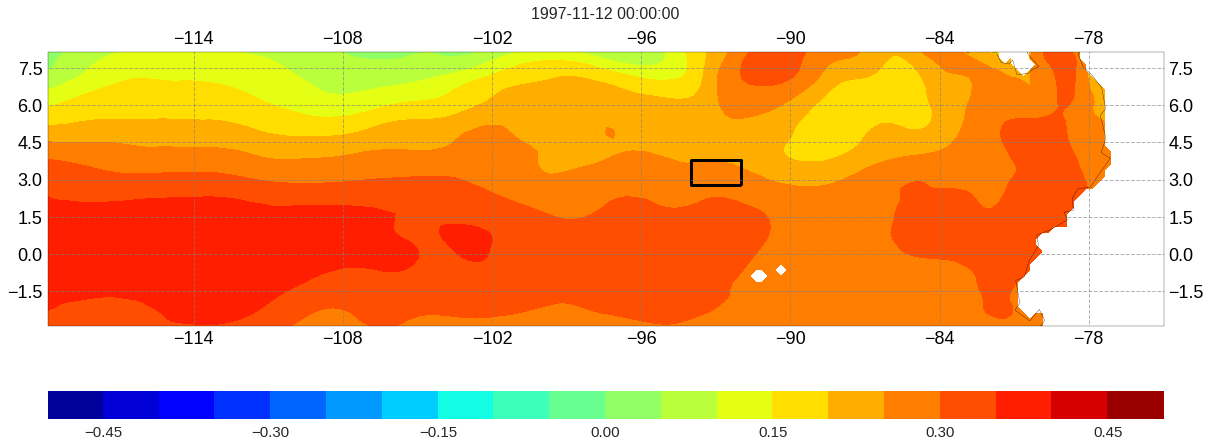

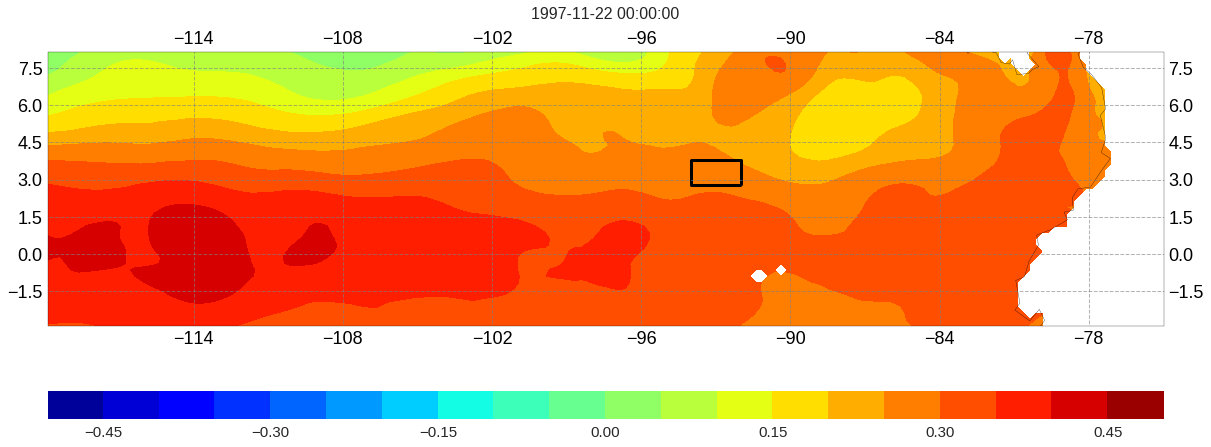

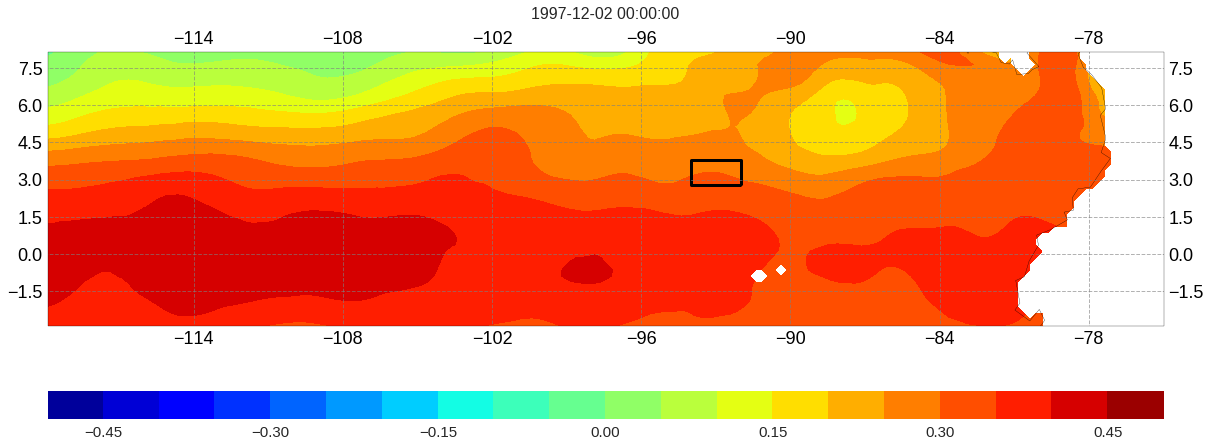

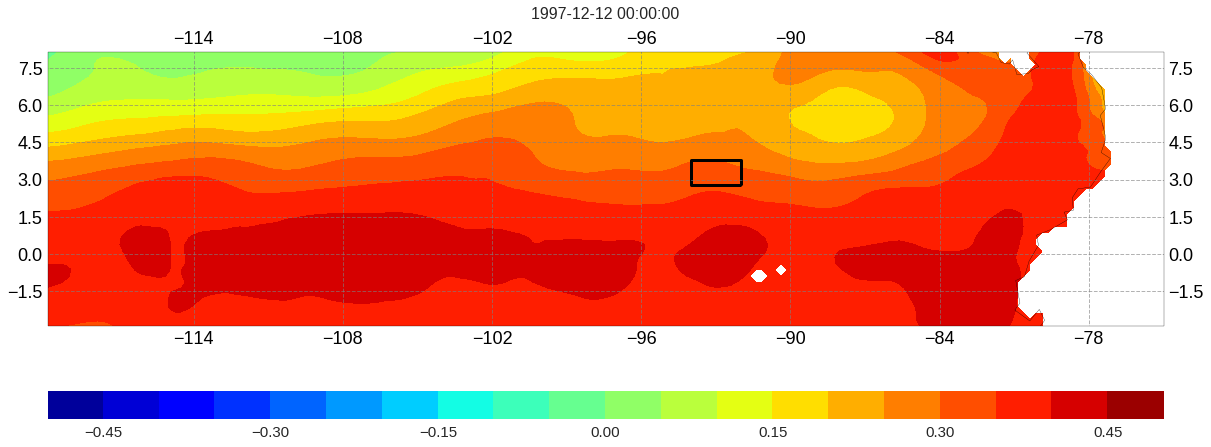

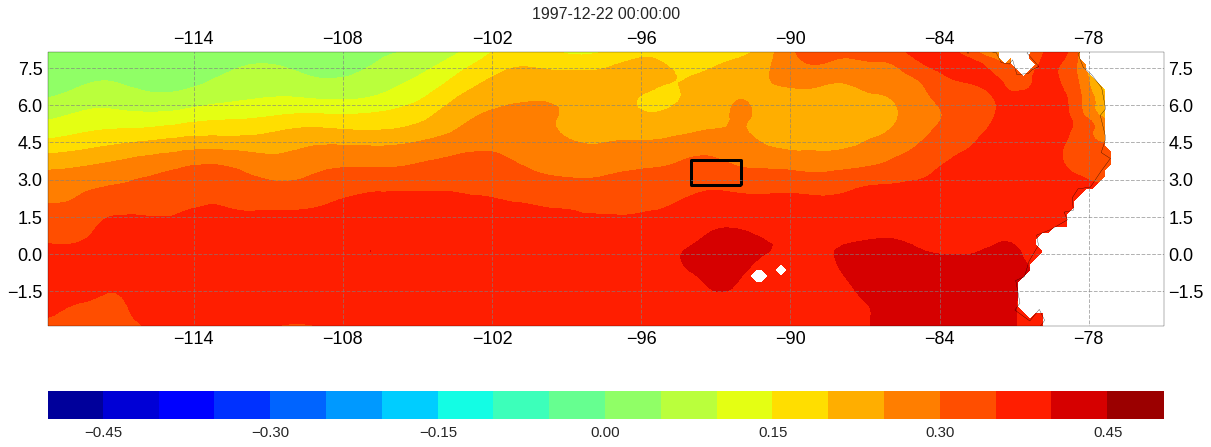

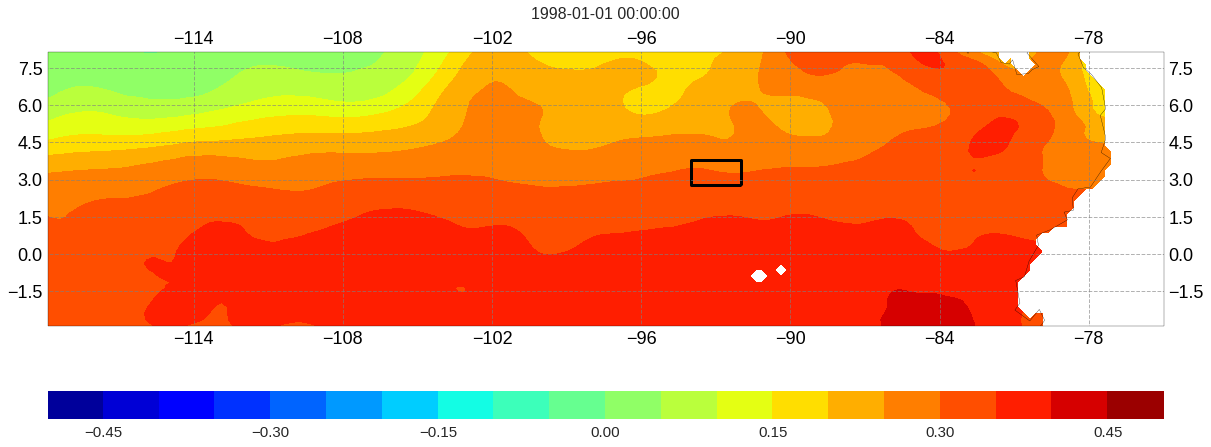

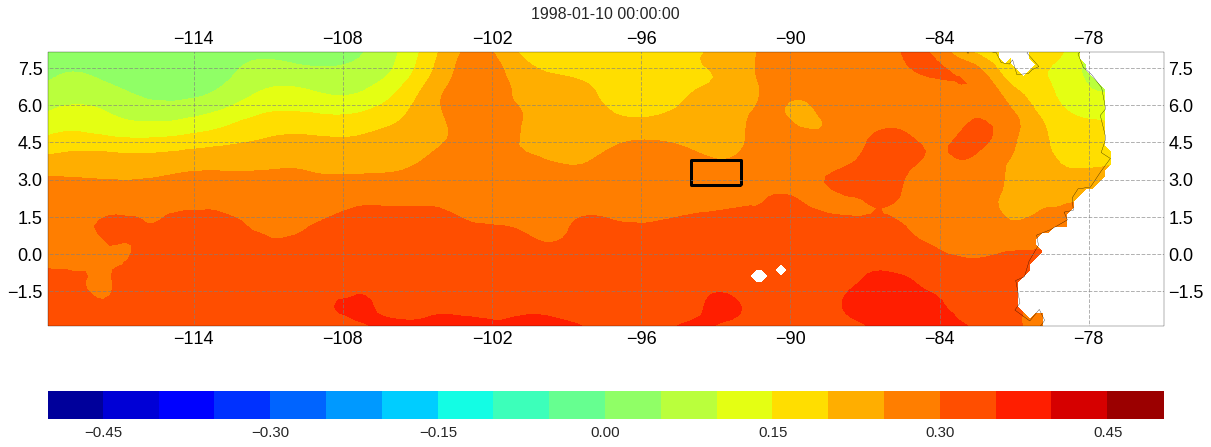

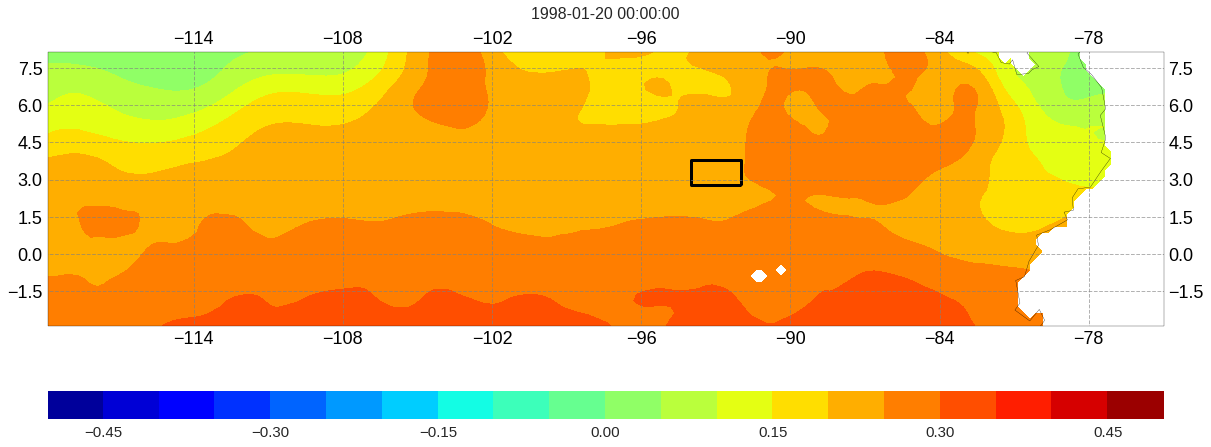

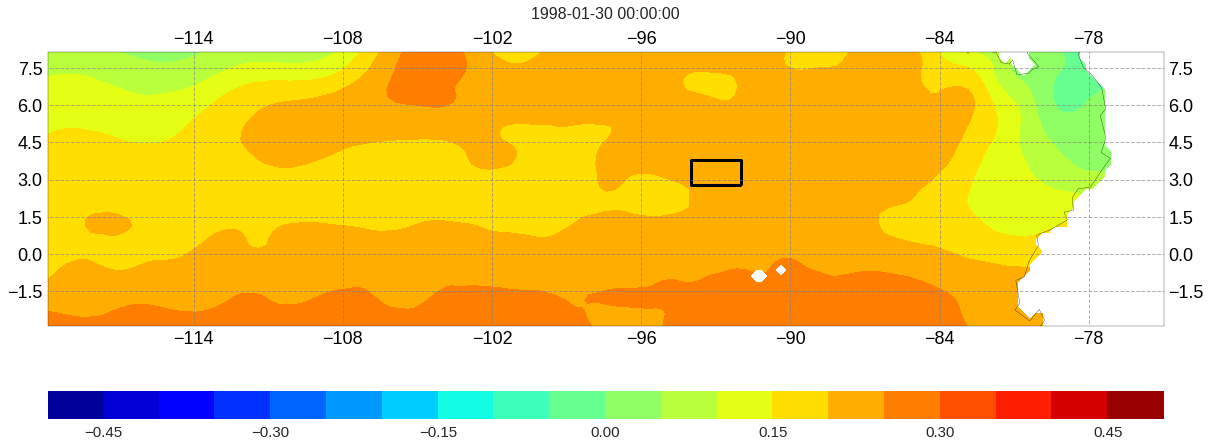

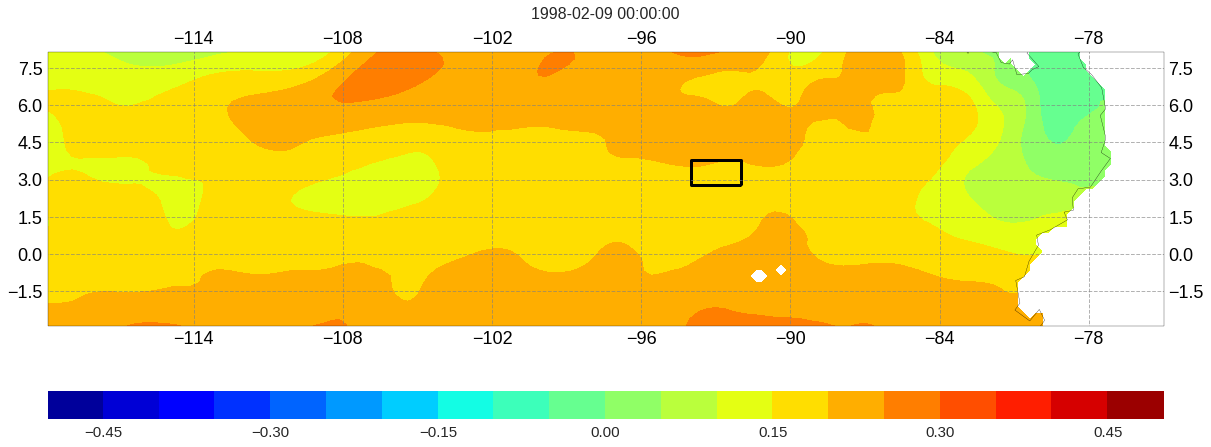

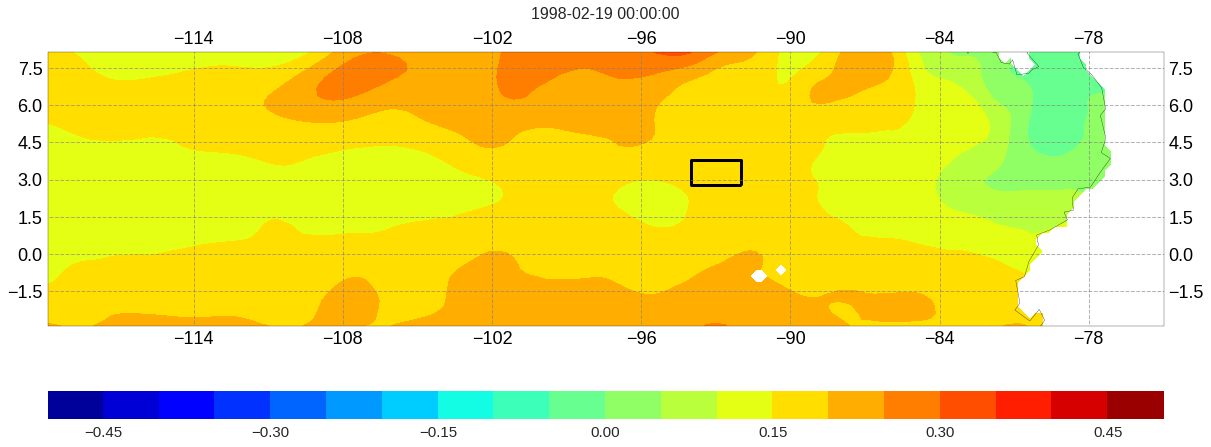

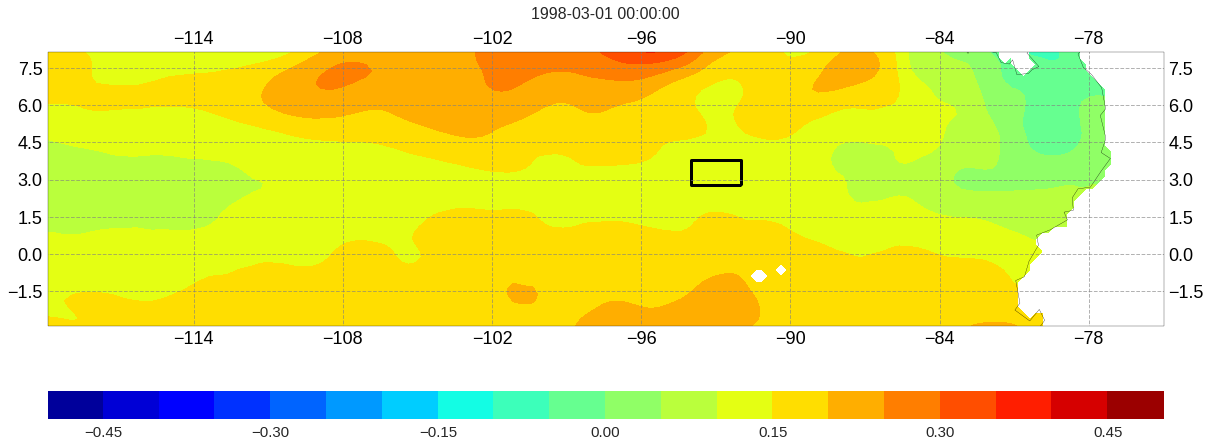

In [255]:
import matplotlib.colors as colors
from shapely.geometry.polygon import LinearRing
lns = [-92, -92, -94, -94]
lts = [2.8, 3.8, 3.8, 2.8]
ring = LinearRing(list(zip(lns, lts)))


for i in range(1700,1900,10):
    fig=plt.figure(figsize=(20,20))
    ax=fig.add_subplot(projection=ccrs.PlateCarree())
    x,y=np.meshgrid(lon,lat)
    
    cf=ax.contourf(x,y,sla[i,:,:],20,transform=ccrs.PlateCarree(),cmap="jet",levels=np.arange(-0.5,0.55,0.05))
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.6, linestyle='--')
    gl.xlabel_style = {'size': 18, 'color': 'black'}
    gl.ylabel_style = {'size': 18, 'color': 'black'}
    ax.coastlines()
    ax.add_geometries([ring], ccrs.PlateCarree(), facecolor="None", edgecolor='black',linewidth=3)
    bound=np.arange(-0.5,0.6,0.1)
    m=mp.cm.ScalarMappable(cmap="jet")
    m.set_array(bound)
    cbar=plt.colorbar(cf,orientation="horizontal",fraction=0.1, pad=0.06,aspect=40,boundaries=np.arange(-0.5,0.6,0.1))
    cbar.ax.tick_params(labelsize=15) 
    plt.title(str(date[i]),y=1.1,fontsize=16)
    plt.savefig('./Plots/GIF_ENSO/enso_'+str(i)+'.png')
    plt.show()

In [256]:
def GIF(ruta,ruta_out,dur):
    from PIL import Image
    import glob
    
    imgs=sorted(glob.glob(ruta))
    frames=[Image.open(i) for i in imgs]
    
    frames[0].save(ruta_out,format='GIF',append_images=frames[0:],
                  save_all=True,duration=dur,loop=0) 
    
    return None

In [257]:
GIF('/home/franklin/Documentos/GitHub/TDG/Scripts/Plots/GIF_ENSO/*.png','ENSO_97_98.gif',300)

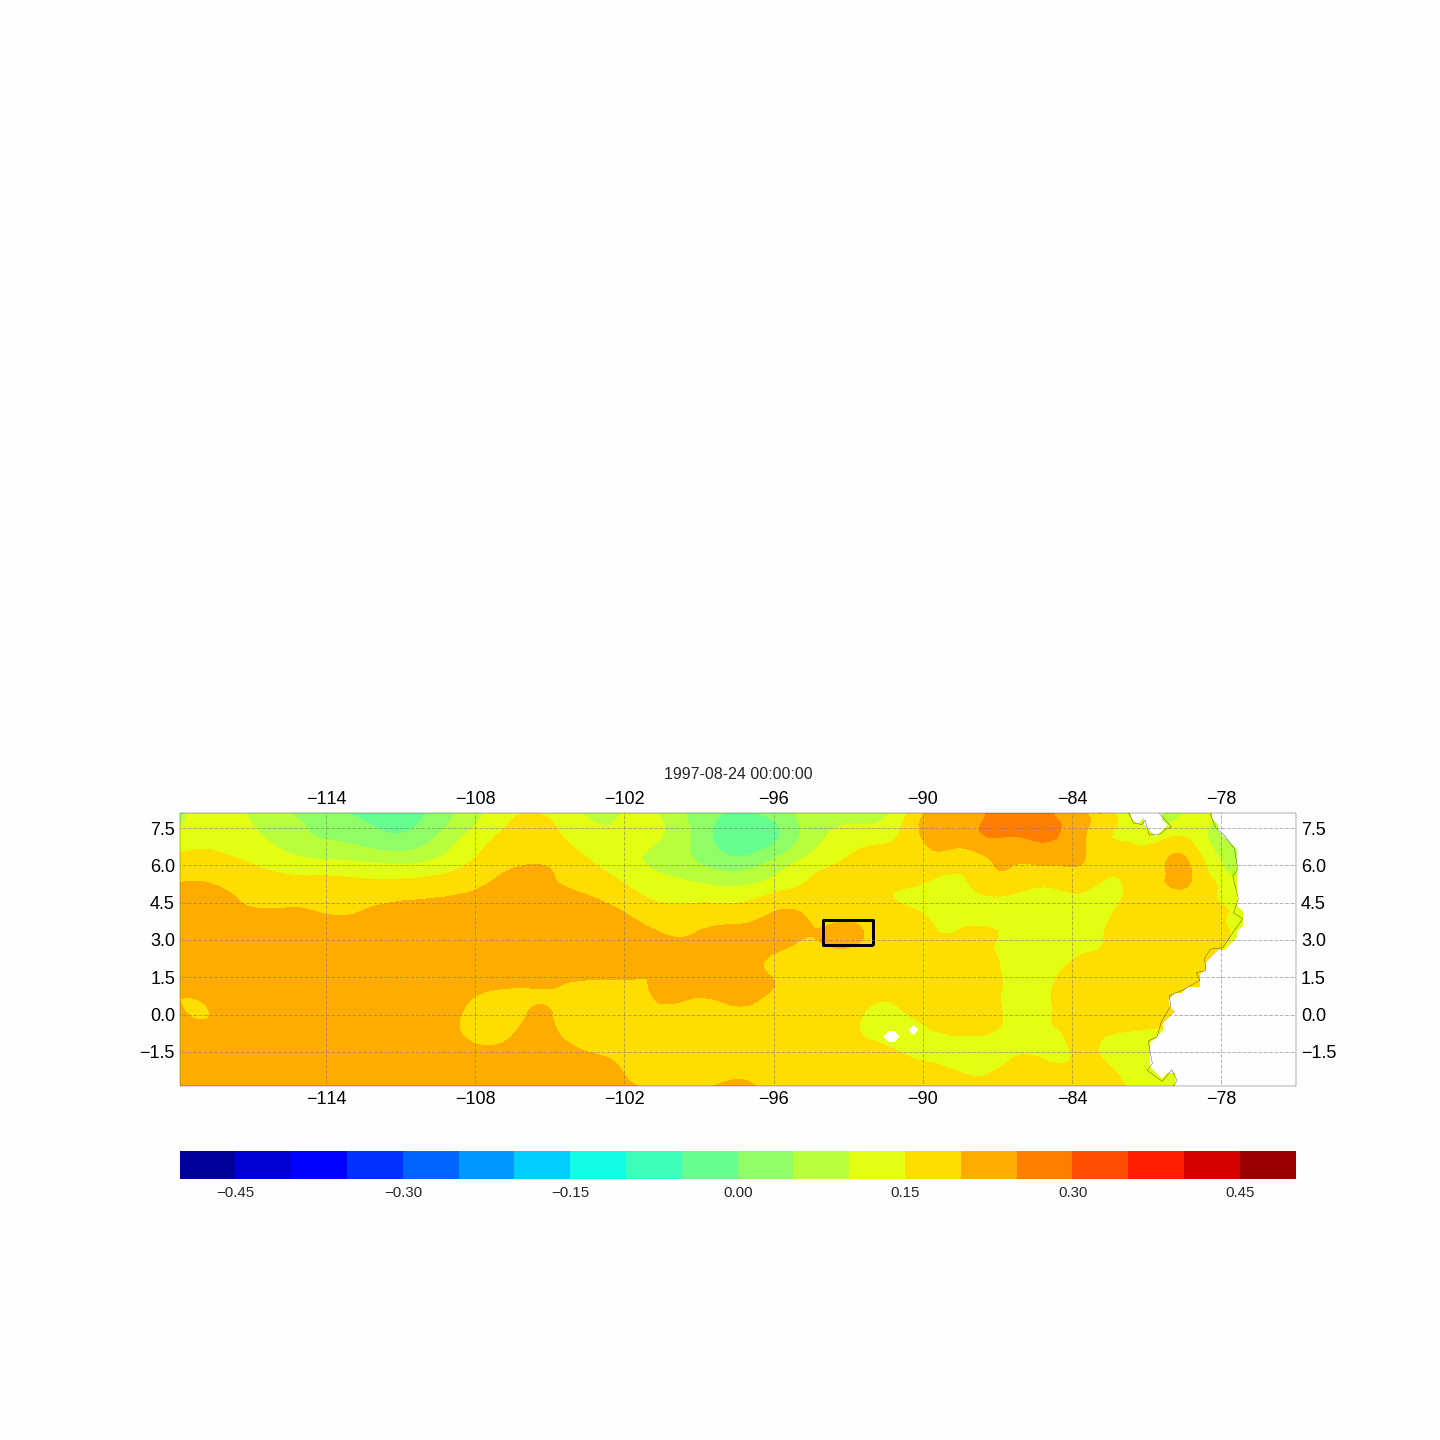

In [258]:
from IPython.display import Image
Image(filename="ENSO_97_98.gif")

In [2]:
import moviepy.editor as mp

clip = mp.VideoFileClip("ENSO_97_98.gif")
clip.write_videofile("ENSO_97_98.mp4")

t:  14%|█▍        | 3/21 [00:00<00:00, 19.65it/s, now=None]

Moviepy - Building video ENSO_97_98.mp4.
Moviepy - Writing video ENSO_97_98.mp4



Moviepy - Done !
Moviepy - video ready ENSO_97_98.mp4
